In [1]:
import pandas as pd
import numpy as np
import os 
from datetime import datetime
import scipy as sp
import time
from datetime import datetime, date, timedelta

from dateutil.relativedelta import relativedelta

import io
from io import StringIO 
#import datedelta
import calendar
import  csv
import json
import random

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats
def add_delta_cols(df):
    #df['delta_vector'] = 0
    #df['delta_max_vector'] = 0

    df['delta_vector'] = 0
    df['delta_max'] = 0
    df['upper_wick'] = 0
    df['lower_wick'] = 0
    
    dv_col = df.columns.get_loc('delta_vector')
    dm_col = df.columns.get_loc('delta_max')
    uw_col = df.columns.get_loc('upper_wick')
    lw_col = df.columns.get_loc('lower_wick')
    
    o_col = df.columns.get_loc('o')
    h_col = df.columns.get_loc('h')
    l_col = df.columns.get_loc('l')
    c_col = df.columns.get_loc('c')
    arr = df.values
    for i in range(arr.shape[0]):
        arr[i,dv_col] = arr[i,c_col] - arr[i,o_col]
        arr[i,dm_col] = arr[i,h_col] - arr[i,l_col]
        if arr[i,c_col] > arr[i,o_col]:
            arr[i,uw_col] = arr[i,h_col] - arr[i,c_col]
            arr[i,lw_col] = arr[i,o_col] - arr[i,l_col]
            
        elif arr[i,c_col] < arr[i,o_col]:
            arr[i,uw_col] = arr[i,h_col] - arr[i,o_col]
            arr[i,lw_col] = arr[i,c_col] - arr[i,l_col]   
            
    df = pd.DataFrame(arr,columns = df.columns)
    df['delta'] = abs(df['delta_vector'])
    
    return df
def load_df(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0)):
    def convert_timestamp(df):
        time_col = df.columns.get_loc('time')
        df['minute_col'] = 0
        df['hour_col'] = 0
        new_col = df.columns.get_loc('minute_col')
        new_col2 = df.columns.get_loc('hour_col')
        arr = df.values 
        for i in range(arr.shape[0]):
            arr[i,new_col] = pd.Timestamp(arr[i,time_col]).minute
            arr[i,new_col2] = pd.Timestamp(arr[i,time_col]).hour
        return pd.DataFrame(arr,columns = df.columns)
    dir_name = os.getcwd() + '/' + pair + '_' + granularity
    path = dir_name + '/' + str(date(start.year,start.month,start.day)) + '_' + str(date(end.year,end.month,end.day)) + '.csv'
    print('PATH:',path)
    df = pd.read_csv(path)
    df = add_delta_cols(df)
    df = convert_timestamp(df)
    df = df.drop_duplicates(subset=['utc_timestamp'])
    print(df.shape)
    return df



def get_support(df,
                df2,
                lookup_range = 1500,
                pip_delta = .001,
                time_range = 11,
                high_spread = .0005,
                low_spread = 0,
                percentile = 98
               ):
    print('GETTING SUPPORT INDICATOR')
    print('LOOKUP RANGE AND PIP DELTA:',lookup_range,pip_delta)
    s = time.time()
    c_col = df.columns.get_loc('c')
    o_col = df.columns.get_loc('o')
    l_col = df.columns.get_loc('l')
    h_col = df.columns.get_loc('h')
    d_col = df.columns.get_loc('delta')
    minute_col = df.columns.get_loc('minute_col')
    df['support_indicator'] = 0
    new_col = df.columns.get_loc('support_indicator')
    arr = df.values
    min_count = 0
    c = 0 
   # high_spread = .0003
    #low_spread = .0001
    #low_spread = 0
    #high_spread = .0005
    min_filter = np.percentile(df2['delta'],percentile)
    
    for i in range(max(lookup_range,time_range + 1),arr.shape[0]):
       # try:
        #DEFINE SUPPORT/RESISTANCE as the MIN or MAX of a lookup range

        if (arr[i - time_range,o_col] - arr[i,c_col]) >= min_filter and arr[i,minute_col] == 55 and sum(arr[i - 50: i,new_col]) == 0:
            arr[i,new_col] = 1

    print('COUNT:',c)

    e = time.time()
    print('TOTAL FUNCTION TIME:',(e-s)/60,' MINUTES')
    df = pd.DataFrame(arr,columns = df.columns)
    print('SUPPORT INDICATOR SHAPE',df[df['support_indicator'] == 1].shape)
    return df
def test_future(df,pair,column = 'support_indicator'):
    if 'JPY' in pair:
        mult = 100
    else:
        mult = 100 * 100
    c_col = df.columns.get_loc('c')
    col = df.columns.get_loc(column)
    
    lst = []
    arr = df.values
    for i in range(arr.shape[0] - 101):
        if arr[i,col] == 1:
            c = arr[i,c_col]

            lst.append([mult * (arr[i + 6,c_col] - c),
                        mult * (arr[i + 12,c_col] - c),
                        mult * (arr[i + 24,c_col] - c),
                        mult * (arr[i + 48,c_col] - c),
                        mult * (arr[i + 100,c_col] - c)                       
                       ])
    df2 = pd.DataFrame(lst,columns = ['next_30','next_hour','next_two_hours','next_four_hours','next_eight_hours'])  
    print('MEDIAN:')
    print(df2.median())
    print()
    print('MEAN:')
    print(df2.mean())
    print()
    print('SUM:')
    print(print(pd.DataFrame(df2.sum()).T))
    
    return pd.DataFrame(df2.median(),columns = [pair]).T,pd.DataFrame(df2.mean(),columns = [pair]).T,pd.DataFrame(df2.sum(),columns = [pair]).T



all_pairs=['GBP_JPY','EUR_USD','USD_JPY','EUR_JPY','AUD_JPY','CAD_JPY','CHF_JPY',
           'GBP_USD','USD_CAD','USD_CHF','AUD_USD',
           'NZD_USD','AUD_CAD','AUD_CHF','AUD_NZD','CAD_CHF',
           'EUR_AUD','EUR_CAD','EUR_CHF','NZD_CAD','NZD_CHF'] 




final_df = pd.DataFrame([0])
final_med = pd.DataFrame([0])
final_mean = pd.DataFrame([0])
final_sum = pd.DataFrame([0])
count = 0
for pair in all_pairs:
    print(pair)  

    if 'JPY' in pair:
        sls = [.05,.075,.1,.125,.15,.2,.25]
        tps = [.1,.15,.2,.25,.3,.4,.5,.7,.9,1.1,1.3,1.5]
        spread = .01
        high_spread = .0005 * 100
        low_spread = 0 * 100
        pip_delta = .005 * 100
    else:
        sls = [.0005,.00075,.001,.00125,.0015,.002,.0025]
        tps = [.001,.0015,.002,.0025,.003,.004,.005,.007,.009,.011,.013,.015]
        spread = .0001
        high_spread = .0005
        low_spread = 0
        pip_delta = .005 

    df = load_df(pair = pair,granularity ='M5',start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0))
    df2 = load_df(pair = pair,granularity ='H4',start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0))
    df = get_support(df,
                     df2,
                lookup_range = 2,
                pip_delta = pip_delta,
                 time_range = 47,
                high_spread = high_spread,
                low_spread = low_spread,
                percentile = 99
               )
    count += df[df['support_indicator'] == 1].shape[0]
    meds,means,sums = test_future(df,pair)
    for j in range(meds.shape[1]):
        if abs(meds.iloc[0,j]) < .01:
            meds.iloc[0,j] = 0
            
    for j in range(means.shape[1]):
        if abs(means.iloc[0,j]) < .01:
            means.iloc[0,j] = 0  
            
    for j in range(sums.shape[1]):
        if abs(sums.iloc[0,j]) < .01:
            sums.iloc[0,j] = 0  
            
    if final_med.shape[1] == 1:
        final_med = meds
        final_mean = means
        final_sum = sums
    else:
        final_med = pd.concat([final_med,meds])
        final_mean = pd.concat([final_mean,means])
        final_sum = pd.concat([final_sum,sums])
print('FINAL TRADE COUNT',count)
final_med

GBP_JPY
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/GBP_JPY_M5/2016-01-01_2022-07-31.csv


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
df.head()

,time,volume,o,h,l,c,utc_timestamp,est_timestamp,smma_21,smma_50,...,new_york,london,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col,support_indicator
0,2016-01-03 22:00:00,10,177.134,177.178,177.13,177.159,2016-01-03 22:00:00+00:00,2016-01-03 17:00:00-05:00,177.159,177.159,...,0,0,0.025,0.048,0.019,0.004,0.025,0,22,0
1,2016-01-03 22:05:00,151,177.154,177.302,177.154,177.268,2016-01-03 22:05:00+00:00,2016-01-03 17:05:00-05:00,177.268,177.268,...,0,0,0.114,0.148,0.034,0.0,0.114,5,22,0
2,2016-01-03 22:10:00,122,177.254,177.292,177.186,177.232,2016-01-03 22:10:00+00:00,2016-01-03 17:10:00-05:00,177.232,177.232,...,0,0,-0.022,0.106,0.038,0.046,0.022,10,22,0
3,2016-01-03 22:15:00,148,177.236,177.274,177.205,177.228,2016-01-03 22:15:00+00:00,2016-01-03 17:15:00-05:00,177.228,177.228,...,0,0,-0.008,0.069,0.038,0.023,0.008,15,22,0
4,2016-01-03 22:20:00,203,177.263,177.295,177.196,177.212,2016-01-03 22:20:00+00:00,2016-01-03 17:20:00-05:00,177.212,177.212,...,0,0,-0.051,0.099,0.032,0.016,0.051,20,22,0


In [3]:
df = load_df(pair = pair,granularity ='M5',start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0))
df2 = load_df(pair = pair,granularity ='H1',start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0))
df3 = load_df(pair = pair,granularity ='H4',start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0))
print(df.shape,df2.shape,df3.shape)

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_M5/2016-01-01_2022-07-31.csv
(490023, 27)
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_H1/2016-01-01_2022-07-31.csv
(41152, 15)
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_H4/2016-01-01_2022-07-31.csv
(10653, 15)
(490023, 27) (41152, 15) (10653, 15)


In [4]:
df.head()

,time,volume,o,h,l,c,utc_timestamp,est_timestamp,smma_21,smma_50,...,bullish_tls,new_york,london,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col
0,2016-01-03 22:00:00,6,1.08743,1.08746,1.08724,1.08726,2016-01-03 22:00:00+00:00,2016-01-03 17:00:00-05:00,1.08726,1.08726,...,0,0,0,-0.00017,0.00022,0.00003,0.00002,0.00017,0,22
1,2016-01-03 22:05:00,53,1.08735,1.08738,1.0871,1.0871,2016-01-03 22:05:00+00:00,2016-01-03 17:05:00-05:00,1.0871,1.0871,...,0,0,0,-0.00025,0.00028,0.00003,0.0,0.00025,5,22
2,2016-01-03 22:10:00,21,1.08715,1.08715,1.08674,1.08681,2016-01-03 22:10:00+00:00,2016-01-03 17:10:00-05:00,1.08681,1.08681,...,0,0,0,-0.00034,0.00041,0.0,0.00007,0.00034,10,22
3,2016-01-03 22:15:00,19,1.08671,1.08694,1.08669,1.0868,2016-01-03 22:15:00+00:00,2016-01-03 17:15:00-05:00,1.0868,1.0868,...,0,0,0,0.00009,0.00025,0.00014,0.00002,0.00009,15,22
4,2016-01-03 22:20:00,47,1.08684,1.08717,1.0867,1.0867,2016-01-03 22:20:00+00:00,2016-01-03 17:20:00-05:00,1.0867,1.0867,...,0,0,0,-0.00014,0.00047,0.00033,0.0,0.00014,20,22


In [5]:
df2

,time,volume,o,h,l,c,utc_timestamp,est_timestamp,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col
0,2016-01-03T22:00:00.000000000Z,289,1.08743,1.08746,1.08667,1.0867,2016-01-03 22:00:00+00:00,2016-01-03 17:00:00-05:00,-0.00073,0.00079,0.00003,0.00003,0.00073,0,22
1,2016-01-03T23:00:00.000000000Z,911,1.08665,1.0867,1.08454,1.08519,2016-01-03 23:00:00+00:00,2016-01-03 18:00:00-05:00,-0.00146,0.00216,0.00005,0.00065,0.00146,0,23
2,2016-01-04T00:00:00.000000000Z,794,1.08524,1.08578,1.08432,1.08454,2016-01-04 00:00:00+00:00,2016-01-03 19:00:00-05:00,-0.0007,0.00146,0.00054,0.00022,0.0007,0,0
3,2016-01-04T01:00:00.000000000Z,1565,1.08456,1.08617,1.08271,1.08597,2016-01-04 01:00:00+00:00,2016-01-03 20:00:00-05:00,0.00141,0.00346,0.0002,0.00185,0.00141,0,1
4,2016-01-04T02:00:00.000000000Z,1728,1.086,1.08757,1.08586,1.08716,2016-01-04 02:00:00+00:00,2016-01-03 21:00:00-05:00,0.00116,0.00171,0.00041,0.00014,0.00116,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41147,2022-08-12T16:00:00.000000000Z,4038,1.02544,1.02618,1.02513,1.02565,2022-08-12 16:00:00+00:00,2022-08-12 12:00:00-04:00,0.00021,0.00105,0.00053,0.00031,0.00021,0,16
41148,2022-08-12T17:00:00.000000000Z,3281,1.02565,1.0268,1.02565,1.02608,2022-08-12 17:00:00+00:00,2022-08-12 13:00:00-04:00,0.00043,0.00115,0.00072,0.0,0.00043,0,17
41149,2022-08-12T18:00:00.000000000Z,2147,1.0261,1.02674,1.02597,1.02654,2022-08-12 18:00:00+00:00,2022-08-12 14:00:00-04:00,0.00044,0.00077,0.0002,0.00013,0.00044,0,18
41150,2022-08-12T19:00:00.000000000Z,2107,1.02652,1.02668,1.02602,1.02606,2022-08-12 19:00:00+00:00,2022-08-12 15:00:00-04:00,-0.00046,0.00066,0.00016,0.00004,0.00046,0,19


In [59]:
def load_df_ml(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0)):
    def engulfing_candle(df):
        print('GETTING ENGULFING CANDLES...')
        df['bearish_engulfing'] = 0
        df['bullish_engulfing'] = 0
        col1 = df.columns.get_loc('bearish_engulfing')
        col2 = df.columns.get_loc('bullish_engulfing')

        open_col = df.columns.get_loc('o')
        close_col = df.columns.get_loc('c')
        arr = df.values 
        for i in range(arr.shape[0]):
            obp = arr[i-1,open_col] #open[1]
            cbp = arr[i-1,close_col] #close[1]
            obc = arr[i,open_col] #open
            cbc = arr[i,close_col] #close        
            #If current bar open is less than equal to the previous bar close AND current bar open is less than previous bar open AND current bar close is greater than previous bar open THEN True
            if obc <= cbp and obc < obp and cbc > obp:
                arr[i+1,col2] = 1

            #If current bar open is greater than equal to previous bar close AND current bar open is greater than previous bar open AND current bar close is less than previous bar open THEN True
            elif obc >= cbp and obc > obp and cbc < obp:    
                arr[i+1,col1] = 1

        return pd.DataFrame(arr,columns = df.columns)


    def three_line_strike(df):
        print('GETTING 3 LINE STRIKE...')
        df['bearish_tls'] = 0
        df['bullish_tls'] = 0
        col1 = df.columns.get_loc('bearish_tls')
        col2 = df.columns.get_loc('bullish_tls')
        open_col = df.columns.get_loc('o')
        close_col = df.columns.get_loc('c')
        arr = df.values 
        for i in range(4,arr.shape[0]):    
            if arr[i - 3,close_col] > arr[i - 3,open_col] and arr[i - 2,close_col] > arr[i - 2,open_col] and arr[i - 1,close_col] > arr[i - 1,open_col] and arr[i,close_col] < arr[i - 1,open_col]: 
                arr[i+1,col1] = 1
            if arr[i - 3,close_col] < arr[i - 3,open_col] and arr[i - 2,close_col] < arr[i - 2,open_col] and arr[i - 1,close_col] < arr[i - 1,open_col] and arr[i,close_col] > arr[i - 1,open_col]: 
                arr[i+1,col2] = 1 

        return pd.DataFrame(arr,columns = df.columns)
    def convert_timestamp(df):
        time_col = df.columns.get_loc('time')
        df['minute_col'] = 0
        df['hour_col'] = 0
        new_col = df.columns.get_loc('minute_col')
        new_col2 = df.columns.get_loc('hour_col')
        arr = df.values 
        for i in range(arr.shape[0]):
            arr[i,new_col] = pd.Timestamp(arr[i,time_col]).minute
            arr[i,new_col2] = pd.Timestamp(arr[i,time_col]).hour
        return pd.DataFrame(arr,columns = df.columns)
    dir_name = os.getcwd() + '/' + pair + '_' + granularity
    path = dir_name + '/' + str(date(start.year,start.month,start.day)) + '_' + str(date(end.year,end.month,end.day)) + '.csv'
    print('PATH:',path)
    df = pd.read_csv(path)
    df = add_delta_cols(df)
    df = convert_timestamp(df)
    df = df.drop_duplicates(subset=['utc_timestamp'])
    df = engulfing_candle(df)
    df = three_line_strike(df)
    
    print(df.shape)
    return df
df_ = load_df_ml(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0))
df_.head()

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_M5/2016-01-01_2022-07-31.csv


KeyboardInterrupt: 

In [53]:
df5 = load_df_ml(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0))
df5.head()

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_M5/2016-01-01_2022-07-31.csv
GETTING ENGULFING CANDLES...
GETTING 3 LINE STRIKE...
(490023, 27)


,time,volume,o,h,l,c,utc_timestamp,est_timestamp,smma_21,smma_50,...,bullish_tls,new_york,london,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col
0,2016-01-03 22:00:00,6,1.08743,1.08746,1.08724,1.08726,2016-01-03 22:00:00+00:00,2016-01-03 17:00:00-05:00,1.08726,1.08726,...,0,0,0,-0.00017,0.00022,0.00003,0.00002,0.00017,0,22
1,2016-01-03 22:05:00,53,1.08735,1.08738,1.0871,1.0871,2016-01-03 22:05:00+00:00,2016-01-03 17:05:00-05:00,1.0871,1.0871,...,0,0,0,-0.00025,0.00028,0.00003,0.0,0.00025,5,22
2,2016-01-03 22:10:00,21,1.08715,1.08715,1.08674,1.08681,2016-01-03 22:10:00+00:00,2016-01-03 17:10:00-05:00,1.08681,1.08681,...,0,0,0,-0.00034,0.00041,0.0,0.00007,0.00034,10,22
3,2016-01-03 22:15:00,19,1.08671,1.08694,1.08669,1.0868,2016-01-03 22:15:00+00:00,2016-01-03 17:15:00-05:00,1.0868,1.0868,...,0,0,0,0.00009,0.00025,0.00014,0.00002,0.00009,15,22
4,2016-01-03 22:20:00,47,1.08684,1.08717,1.0867,1.0867,2016-01-03 22:20:00+00:00,2016-01-03 17:20:00-05:00,1.0867,1.0867,...,0,0,0,-0.00014,0.00047,0.00033,0.0,0.00014,20,22


In [66]:
test.columns

Index(['utc_timestamp', 'hour_col', 'bearish_engulfing', 'bullish_engulfing',
       'bearish_tls', 'bullish_tls', 'pair', 'previous_hour_volume',
       'previous_4_hour_volume', 'previous_bullish_hour',
       'previous_bullish_4hour', 'previous_bullish_8hour',
       'previous_bullish_24hour', 'previous_bullish_50hour',
       'previous_bullish_120hour', 'previous_bullish_250hour',
       'previous_bullish_400hour', 'previous_delta_hour',
       'previous_delta_4hour', 'previous_delta_8hour', 'previous_delta_24hour',
       'previous_delta_50hour', 'previous_delta_120hour',
       'previous_delta_250hour', 'previous_delta_400hour',
       'previous_lower_wick_hour', 'previous_upper_wick_hour',
       'low_at_low_of_last_day', 'low_at_low_of_last_5day',
       'low_at_low_of_last_10day', 'low_at_low_of_last_20day',
       'high_at_high_of_last_day', 'high_at_high_of_last_5day',
       'high_at_high_of_last_10day', 'high_at_high_of_last_20day',
       'close_difference_from_low_close_

In [65]:
df5.columns

Index(['time', 'volume', 'o', 'h', 'l', 'c', 'utc_timestamp', 'est_timestamp',
       'smma_21', 'smma_50', 'smma_200', 'ema_42', 'ema_150', 'ema_600',
       'bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'new_york', 'london', 'delta_vector', 'delta_max', 'upper_wick',
       'lower_wick', 'delta', 'minute_col', 'hour_col'],
      dtype='object')

In [74]:
def get_5_min_features(df,pair):
    if 'JPY' in pair:
        mult = 100
    else:
        mult = 100 * 100
        
        
    df['previous_5_min_volume'] = 0
    df['previous_15_min_volume'] = 0
    df['bullish_ema_5min'] = 0
    df['bearish_ema_5min'] = 0
    df['previous_bullish_5min'] = 0
    df['previous_delta_5min'] = 0

    vol = df.columns.get_loc('volume')
    vol_5 = df.columns.get_loc('previous_5_min_volume')
    vol_15 = df.columns.get_loc('previous_15_min_volume')
    
    ema1 = df.columns.get_loc('ema_42')
    ema2 = df.columns.get_loc('ema_150')
    ema3 = df.columns.get_loc('ema_600')
    bullish_ema = df.columns.get_loc('bullish_ema_5min')
    bearish_ema = df.columns.get_loc('bearish_ema_5min')
    
    o_col = df.columns.get_loc('o')
    c_col = df.columns.get_loc('c')
    d_col = df.columns.get_loc('delta')
    bull_col = df.columns.get_loc('previous_bullish_5min')
    delta_col = df.columns.get_loc('previous_delta_5min')    

    arr = df.values
    for i in range(arr.shape[0]):
        arr[i,vol_5] = arr[i-1,vol]
        arr[i,vol_15] = sum(arr[i-3:i,vol])
        if arr[i-1,ema1] > arr[i-1,ema2] and  arr[i-1,ema2] > arr[i-1,ema3]:
            arr[i,bullish_ema] = 1
        elif arr[i-1,ema1] < arr[i-1,ema2] and  arr[i-1,ema2] < arr[i-1,ema3]:
            arr[i,bearish_ema] = 1   
            
        if arr[i-1,o_col] < arr[i-1,c_col]:
            arr[i,bull_col] = 1
        arr[i,delta_col] = mult * arr[i-1,d_col]
        
    df = pd.DataFrame(arr,columns = df.columns)
    
    df['bearish_engulfing5'] = df['bearish_engulfing']
    df['bullish_engulfing5'] = df['bullish_engulfing']
    df['bearish_tls5'] = df['bearish_tls']
    df['bullish_tls5'] = df['bullish_tls']
    df = df[df['minute_col'] == 0]
    
    df = df.drop(columns = ['time', 'volume', 'o', 'h', 'l', 'c', 'est_timestamp',
       'smma_21', 'smma_50', 'smma_200', 'ema_42', 'ema_150', 'ema_600',
       'bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'new_york', 'london', 'delta_vector', 'delta_max', 'upper_wick',
       'lower_wick', 'delta', 'minute_col', 'hour_col'])
    
    return df


df5 = load_df_ml(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0))  

df5 = get_5_min_features(df5,pair)
df5.head()

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_M5/2016-01-01_2022-07-31.csv
GETTING ENGULFING CANDLES...
GETTING 3 LINE STRIKE...
(490023, 27)


,utc_timestamp,previous_5_min_volume,previous_15_min_volume,bullish_ema_5min,bearish_ema_5min,previous_bullish_5min,previous_delta_5min,bearish_engulfing5,bullish_engulfing5,bearish_tls5,bullish_tls5
0,2016-01-03 22:00:00+00:00,423,0,0,0,1,1.5,0,0,0,0
12,2016-01-03 23:00:00+00:00,3,67,0,0,1,0.2,0,0,0,0
24,2016-01-04 00:00:00+00:00,40,120,0,0,0,0.1,0,0,0,0
36,2016-01-04 01:00:00+00:00,51,206,0,0,0,0.2,0,0,0,0
48,2016-01-04 02:00:00+00:00,148,593,0,0,1,2.7,0,0,0,0


In [76]:
df5.shape

(40939, 11)

In [75]:
test.shape

(40671, 47)

In [80]:
df5[~df5['utc_timestamp'].isin(test['utc_timestamp'])].tail(10)

,utc_timestamp,previous_5_min_volume,previous_15_min_volume,bullish_ema_5min,bearish_ema_5min,previous_bullish_5min,previous_delta_5min,bearish_engulfing5,bullish_engulfing5,bearish_tls5,bullish_tls5
5649,2016-01-29 13:00:00+00:00,145,341,0,0,1,6.3,0,0,0,0
5661,2016-01-29 14:00:00+00:00,321,1204,0,0,0,3.5,0,0,0,0
5673,2016-01-29 15:00:00+00:00,285,1087,0,1,1,3.9,0,0,0,0
5685,2016-01-29 16:00:00+00:00,405,921,0,1,0,14.1,1,0,0,0
5697,2016-01-29 17:00:00+00:00,206,691,0,1,1,8.1,0,0,0,0
5709,2016-01-29 18:00:00+00:00,217,392,0,1,1,7.0,0,0,0,0
5721,2016-01-29 19:00:00+00:00,114,359,0,1,0,5.1,0,0,0,0
5733,2016-01-29 20:00:00+00:00,106,209,0,1,0,3.8,0,0,0,0
5745,2016-01-29 21:00:00+00:00,31,153,0,1,0,0.6,0,0,0,0
5757,2016-01-31 22:00:00+00:00,103,156,0,1,0,1.6,0,0,0,0


In [81]:
test = test.merge(df5,how = 'inner',on = 'utc_timestamp')
test.head()

,utc_timestamp,hour_col,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,pair,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,...,previous_5_min_volume,previous_15_min_volume,bullish_ema_5min,bearish_ema_5min,previous_bullish_5min,previous_delta_5min,bearish_engulfing5,bullish_engulfing5,bearish_tls5,bullish_tls5
0,2016-01-31 23:00:00+00:00,23,0,0,0,0,EUR_USD,375,2205,0,...,55,125,0,1,0,0.5,0,0,0,0
1,2016-02-01 00:00:00+00:00,0,0,0,0,0,EUR_USD,764,2235,0,...,36,120,0,1,1,2.2,0,0,0,0
2,2016-02-01 01:00:00+00:00,1,0,0,0,1,EUR_USD,945,2479,1,...,59,158,0,1,1,1.6,0,0,0,0
3,2016-02-01 02:00:00+00:00,2,0,0,0,0,EUR_USD,837,2921,0,...,10,183,0,1,0,1.0,0,0,0,0
4,2016-02-01 03:00:00+00:00,3,0,0,0,0,EUR_USD,569,3115,1,...,25,69,0,1,0,0.7,0,0,0,0


In [7]:
df_[df_['bullish_tls'] == 1].shape

(12995, 27)

In [ ]:
df[df_['bullish_tls'] == 1].shape

In [8]:
df = load_df(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0))
df[df['bullish_tls'] == 1].shape

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_M5/2016-01-01_2022-07-31.csv
(490023, 27)


(12995, 27)

In [56]:
df = load_df_ml(pair = 'EUR_USD'
            ,granularity = 'H1'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0))
df.head()

PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_USD_H1/2016-01-01_2022-07-31.csv
GETTING ENGULFING CANDLES...
GETTING 3 LINE STRIKE...
(41152, 19)


,time,volume,o,h,l,c,utc_timestamp,est_timestamp,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls
0,2016-01-03T22:00:00.000000000Z,289,1.08743,1.08746,1.08667,1.0867,2016-01-03 22:00:00+00:00,2016-01-03 17:00:00-05:00,-0.00073,0.00079,0.00003,0.00003,0.00073,0,22,0,0,0,0
1,2016-01-03T23:00:00.000000000Z,911,1.08665,1.0867,1.08454,1.08519,2016-01-03 23:00:00+00:00,2016-01-03 18:00:00-05:00,-0.00146,0.00216,0.00005,0.00065,0.00146,0,23,0,0,0,0
2,2016-01-04T00:00:00.000000000Z,794,1.08524,1.08578,1.08432,1.08454,2016-01-04 00:00:00+00:00,2016-01-03 19:00:00-05:00,-0.0007,0.00146,0.00054,0.00022,0.0007,0,0,0,0,0,0
3,2016-01-04T01:00:00.000000000Z,1565,1.08456,1.08617,1.08271,1.08597,2016-01-04 01:00:00+00:00,2016-01-03 20:00:00-05:00,0.00141,0.00346,0.0002,0.00185,0.00141,0,1,0,0,0,0
4,2016-01-04T02:00:00.000000000Z,1728,1.086,1.08757,1.08586,1.08716,2016-01-04 02:00:00+00:00,2016-01-03 21:00:00-05:00,0.00116,0.00171,0.00041,0.00014,0.00116,0,2,0,0,0,0


In [11]:
i = 10
df.iloc[i,:]

time                 2016-01-04T08:00:00.000000000Z
volume                                         3987
o                                           1.09132
h                                           1.09464
l                                           1.09109
c                                           1.09242
utc_timestamp             2016-01-04 08:00:00+00:00
est_timestamp             2016-01-04 03:00:00-05:00
delta_vector                                 0.0011
delta_max                                   0.00355
upper_wick                                  0.00222
lower_wick                                  0.00023
delta                                        0.0011
minute_col                                        0
hour_col                                          8
bearish_engulfing                                 0
bullish_engulfing                                 0
bearish_tls                                       0
bullish_tls                                       0
Name: 10, dt

In [12]:
df.iloc[i - 4:i,:]

,time,volume,o,h,l,c,utc_timestamp,est_timestamp,delta_vector,delta_max,upper_wick,lower_wick,delta,minute_col,hour_col,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls
6,2016-01-04T04:00:00.000000000Z,984,1.08717,1.08836,1.08697,1.08793,2016-01-04 04:00:00+00:00,2016-01-03 23:00:00-05:00,0.00076,0.00139,0.00043,0.0002,0.00076,0,4,0,0,0,0
7,2016-01-04T05:00:00.000000000Z,1501,1.0879,1.09048,1.08739,1.08972,2016-01-04 05:00:00+00:00,2016-01-04 00:00:00-05:00,0.00182,0.00309,0.00076,0.00051,0.00182,0,5,0,0,0,0
8,2016-01-04T06:00:00.000000000Z,1073,1.0897,1.09024,1.08842,1.08888,2016-01-04 06:00:00+00:00,2016-01-04 01:00:00-05:00,-0.00082,0.00182,0.00054,0.00046,0.00082,0,6,0,0,0,0
9,2016-01-04T07:00:00.000000000Z,3110,1.08891,1.09204,1.08818,1.09127,2016-01-04 07:00:00+00:00,2016-01-04 02:00:00-05:00,0.00236,0.00386,0.00077,0.00073,0.00236,0,7,0,0,0,0


In [5]:
(((3317.80 * 145000) / 140000) * (26/ 12))

7445.30119047619

In [7]:
(3317.80 * 145000) / 140000

3436.292857142857

In [9]:
538 - 218

320

In [ ]:
date_ranges
for start,end in 

In [13]:
df.iloc[i - 1,:]

time                 2016-01-04T07:00:00.000000000Z
volume                                         3110
o                                           1.08891
h                                           1.09204
l                                           1.08818
c                                           1.09127
utc_timestamp             2016-01-04 07:00:00+00:00
est_timestamp             2016-01-04 02:00:00-05:00
delta_vector                                0.00236
delta_max                                   0.00386
upper_wick                                  0.00077
lower_wick                                  0.00073
delta                                       0.00236
minute_col                                        0
hour_col                                          7
bearish_engulfing                                 0
bullish_engulfing                                 0
bearish_tls                                       0
bullish_tls                                       0
Name: 9, dty

In [60]:
def load_df_ml(pair = 'EUR_USD'
            ,granularity = 'M5'
            ,start = datetime(2016,1,1,0,0,0)
            ,end = datetime(2022,7,31,0,0,0)):
    def engulfing_candle(df):
        print('GETTING ENGULFING CANDLES...')
        df['bearish_engulfing'] = 0
        df['bullish_engulfing'] = 0
        col1 = df.columns.get_loc('bearish_engulfing')
        col2 = df.columns.get_loc('bullish_engulfing')

        open_col = df.columns.get_loc('o')
        close_col = df.columns.get_loc('c')
        arr = df.values 
        for i in range(arr.shape[0] - 1):
            obp = arr[i-1,open_col] #open[1]
            cbp = arr[i-1,close_col] #close[1]
            obc = arr[i,open_col] #open
            cbc = arr[i,close_col] #close        
            #If current bar open is less than equal to the previous bar close AND current bar open is less than previous bar open AND current bar close is greater than previous bar open THEN True
            if obc <= cbp and obc < obp and cbc > obp:
                arr[i+1,col2] = 1

            #If current bar open is greater than equal to previous bar close AND current bar open is greater than previous bar open AND current bar close is less than previous bar open THEN True
            elif obc >= cbp and obc > obp and cbc < obp:    
                arr[i+1,col1] = 1

        return pd.DataFrame(arr,columns = df.columns)
    def smma(df,period = 14):
        print('GETTING SMMA INDICATOR FOR:',period)
        close_col = df.columns.get_loc('c')
        df['smma_' + str(period)] = df['c']
        smma_col = df.columns.get_loc('smma_' + str(period))
        arr = df.values

        #SMMA CALC:

        #SUM1=SUM (CLOSE, N)

        #SMMA1 = SUM1/ N

        #The second and subsequent moving averages are calculated according to this formula:

        #SMMA (i) = (SUM1 – SMMA1+CLOSE (i))/ N    

       # Where:

        #SUM1 – is the total sum of closing prices for N periods;
        #SMMA1 – is the smoothed moving average of the first bar;
        #SMMA (i) – is the smoothed moving average of the current bar (except the first one);
        #CLOSE (i) – is the current closing price;
        #N – is the smoothing period.    

        for i in range(period,arr.shape[0]):
            if i == period:
                sum1 = sum(arr[:i,close_col])

                smma1 = sum1 / period

                arr[i,smma_col] = smma1
            elif i == period + 1:
                arr[i,smma_col] = (smma1 * (period - 1) + arr[i,close_col]) / period

            else:

                prev_sum = arr[i - 1,smma_col] * period
                arr[i,smma_col] = (prev_sum - arr[i - 1,smma_col] + arr[i,close_col]) / period


        return pd.DataFrame(arr,columns = df.columns)
    def convert_timestamp2(df):
        time_col = df.columns.get_loc('time')
        arr = df.values 
        for i in range(arr.shape[0]):
            arr[i,time_col] = datetime.strptime(arr[i,time_col][:-4], '%Y-%m-%dT%H:%M:%S.%f')
        return pd.DataFrame(arr,columns = df.columns)

    def get_trading_session(df,london_start = 7,london_end = 16,ny_start = 13,ny_end = 22):
        print('GETTING TRADING SESSIONS')
        print('LONDON TRADING SESSION UTC',london_start,london_end)
        print('NEW YORK TRADING SESSION UTC',ny_start,ny_end)
        df['new_york'] = 0
        df['london'] = 0


        col1 = df.columns.get_loc('new_york')
        col2 = df.columns.get_loc('london')
        utc = df.columns.get_loc('time')
        arr = df.values 

        for i in range(arr.shape[0]):
            if arr[i,utc].hour >= london_start and arr[i,utc].hour < london_end:
                arr[i,col2] = 1
            if arr[i,utc].hour >= ny_start and arr[i,utc].hour < ny_end:
                arr[i,col1] = 1     
        return pd.DataFrame(arr,columns = df.columns)

    def three_line_strike(df):
        print('GETTING 3 LINE STRIKE...')
        df['bearish_tls'] = 0
        df['bullish_tls'] = 0
        col1 = df.columns.get_loc('bearish_tls')
        col2 = df.columns.get_loc('bullish_tls')
        open_col = df.columns.get_loc('o')
        close_col = df.columns.get_loc('c')
        arr = df.values 
        for i in range(4,arr.shape[0] - 1):    
            if arr[i - 3,close_col] > arr[i - 3,open_col] and arr[i - 2,close_col] > arr[i - 2,open_col] and arr[i - 1,close_col] > arr[i - 1,open_col] and arr[i,close_col] < arr[i - 1,open_col]: 
                arr[i+1,col1] = 1
            if arr[i - 3,close_col] < arr[i - 3,open_col] and arr[i - 2,close_col] < arr[i - 2,open_col] and arr[i - 1,close_col] < arr[i - 1,open_col] and arr[i,close_col] > arr[i - 1,open_col]: 
                arr[i+1,col2] = 1 

        return pd.DataFrame(arr,columns = df.columns)
    def ema(df,num = 14):
        print('GETTING EMA INDICATOR FOR:',num)
        close_col = df.columns.get_loc('c')
        df['ema_' + str(num)] = df['c']
        arr = df.values
        mult = 2/ (num + 1)
        for i in range(num,arr.shape[0]):
            sma = sum(arr[i - num + 1: i + 1,close_col]) / num
            arr[i,-1] = ((arr[i,close_col] - arr[i - 1,-1]) * mult) + arr[i - 1,-1]
        return pd.DataFrame(arr,columns = df.columns)

    def convert_timestamp(df):
        time_col = df.columns.get_loc('time')
        df['minute_col'] = 0
        df['hour_col'] = 0
        new_col = df.columns.get_loc('minute_col')
        new_col2 = df.columns.get_loc('hour_col')
        arr = df.values 
        for i in range(arr.shape[0]):
            arr[i,new_col] = pd.Timestamp(arr[i,time_col]).minute
            arr[i,new_col2] = pd.Timestamp(arr[i,time_col]).hour
        return pd.DataFrame(arr,columns = df.columns)
    
    
    dir_name = os.getcwd() + '/' + pair + '_' + granularity
    path = dir_name + '/' + str(date(start.year,start.month,start.day)) + '_' + str(date(end.year,end.month,end.day)) + '.csv'
    print('PATH:',path)
    df = pd.read_csv(path)
    df = add_delta_cols(df)
    df = convert_timestamp(df)
    df = df.drop_duplicates(subset=['utc_timestamp'])
    df = engulfing_candle(df)
    df = three_line_strike(df)
    df = ema(df,num = 14 * 3)
    df = ema(df,num = 50 * 3)
    df = ema(df,num = 200 * 3)
    
    df = smma(df,period = 21)
    df = smma(df,period = 50)
    df = smma(df,period = 200)
    try:
        df = convert_timestamp2(df)
        df = get_trading_session(df,london_start = 7,london_end = 16,ny_start = 13,ny_end = 22)
    except:
        pass
    print(df.shape)
    return df

def get_5_min_features(df,pair):
    if 'JPY' in pair:
        mult = 100
    else:
        mult = 100 * 100
        
        
    df['previous_5_min_volume'] = 0
    df['previous_15_min_volume'] = 0
    df['bullish_ema_5min'] = 0
    df['bearish_ema_5min'] = 0
    df['previous_bullish_5min'] = 0
    df['previous_delta_5min'] = 0

    vol = df.columns.get_loc('volume')
    vol_5 = df.columns.get_loc('previous_5_min_volume')
    vol_15 = df.columns.get_loc('previous_15_min_volume')
    
    ema1 = df.columns.get_loc('ema_42')
    ema2 = df.columns.get_loc('ema_150')
    ema3 = df.columns.get_loc('ema_600')
    bullish_ema = df.columns.get_loc('bullish_ema_5min')
    bearish_ema = df.columns.get_loc('bearish_ema_5min')
    
    o_col = df.columns.get_loc('o')
    c_col = df.columns.get_loc('c')
    d_col = df.columns.get_loc('delta')
    bull_col = df.columns.get_loc('previous_bullish_5min')
    delta_col = df.columns.get_loc('previous_delta_5min')    

    arr = df.values
    for i in range(arr.shape[0]):
        arr[i,vol_5] = arr[i-1,vol]
        arr[i,vol_15] = sum(arr[i-3:i,vol])
        if arr[i-1,ema1] > arr[i-1,ema2] and  arr[i-1,ema2] > arr[i-1,ema3]:
            arr[i,bullish_ema] = 1
        elif arr[i-1,ema1] < arr[i-1,ema2] and  arr[i-1,ema2] < arr[i-1,ema3]:
            arr[i,bearish_ema] = 1   
            
        if arr[i-1,o_col] < arr[i-1,c_col]:
            arr[i,bull_col] = 1
        arr[i,delta_col] = mult * arr[i-1,d_col]
        
    df = pd.DataFrame(arr,columns = df.columns)
    
    df['bearish_engulfing5'] = df['bearish_engulfing']
    df['bullish_engulfing5'] = df['bullish_engulfing']
    df['bearish_tls5'] = df['bearish_tls']
    df['bullish_tls5'] = df['bullish_tls']
    df = df[df['minute_col'] == 0]
    
    df = df.drop(columns = ['time', 'volume', 'o', 'h', 'l', 'c', 'est_timestamp',
       'smma_21', 'smma_50', 'smma_200', 'ema_42', 'ema_150', 'ema_600',
       'bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'new_york', 'london', 'delta_vector', 'delta_max', 'upper_wick',
       'lower_wick', 'delta', 'minute_col', 'hour_col'])
    
    return df



def get_ml_features(df,sl,tp,bullish,pair):
    if 'JPY' in pair:
        mult = 100
    else:
        mult = 100 * 100
    volume_col = df.columns.get_loc('volume')
    
    df['target'] = 0
    df['pair'] = pair
    df['previous_hour_volume'] = 0
    df['previous_4_hour_volume'] = 0
    df['previous_bullish_hour'] = 0
    df['previous_bullish_4hour'] = 0
    df['previous_bullish_8hour'] = 0
    df['previous_bullish_24hour'] = 0
    df['previous_bullish_50hour'] = 0
    df['previous_bullish_120hour'] = 0
    df['previous_bullish_250hour'] = 0
    df['previous_bullish_400hour'] = 0  
    
    df['previous_delta_hour'] = 0
    df['previous_delta_4hour'] = 0
    df['previous_delta_8hour'] = 0
    df['previous_delta_24hour'] = 0
    df['previous_delta_50hour'] = 0
    df['previous_delta_120hour'] = 0
    df['previous_delta_250hour'] = 0
    df['previous_delta_400hour'] = 0  
    df['previous_lower_wick_hour'] = 0
    df['previous_upper_wick_hour'] = 0 

    df['low_at_low_of_last_day'] = 0
    df['low_at_low_of_last_5day'] = 0
    df['low_at_low_of_last_10day'] = 0
    df['low_at_low_of_last_20day'] = 0
    df['high_at_high_of_last_day'] = 0
    df['high_at_high_of_last_5day'] = 0
    df['high_at_high_of_last_10day'] = 0
    df['high_at_high_of_last_20day'] = 0
    
    
    df['close_difference_from_low_close_of_last_day'] = 0
    df['close_difference_from_low_close_of_last_5day'] = 0
    df['close_difference_from_low_close_of_last_10day'] = 0
    df['close_difference_from_high_close_of_last_day'] = 0
    df['close_difference_from_high_close_of_last_5day'] = 0
    df['close_difference_from_high_close_of_last_10day'] = 0 
    
    df['hour_0_3'] = 0
    df['hour_4_7'] = 0
    df['hour_8_11'] = 0
    df['hour_12_15'] = 0
    df['hour_16_19'] = 0
    df['hour_20_23'] = 0


    o_col = df.columns.get_loc('o')
    h_col = df.columns.get_loc('h')
    l_col = df.columns.get_loc('l')
    c_col = df.columns.get_loc('c')
    
    previous_volume_col = df.columns.get_loc('previous_hour_volume')
    previous_4_volume_col = df.columns.get_loc('previous_4_hour_volume')
    
    previous_bullish_hour_col = df.columns.get_loc('previous_bullish_hour')
    previous_bullish_4hour_col = df.columns.get_loc('previous_bullish_4hour')    
    previous_bullish_8hour_col = df.columns.get_loc('previous_bullish_8hour')
    previous_bullish_24hour_col = df.columns.get_loc('previous_bullish_24hour')  
    previous_bullish_50hour_col = df.columns.get_loc('previous_bullish_50hour')
    previous_bullish_120hour_col = df.columns.get_loc('previous_bullish_120hour')  
    previous_bullish_250hour_col = df.columns.get_loc('previous_bullish_250hour')
    previous_bullish_400hour_col = df.columns.get_loc('previous_bullish_400hour')  
    
    previous_delta_hour_col = df.columns.get_loc('previous_delta_hour')
    previous_delta_4hour_col = df.columns.get_loc('previous_delta_4hour')    
    previous_delta_8hour_col = df.columns.get_loc('previous_delta_8hour')
    previous_delta_24hour_col = df.columns.get_loc('previous_delta_24hour')  
    previous_delta_50hour_col = df.columns.get_loc('previous_delta_50hour')
    previous_delta_120hour_col = df.columns.get_loc('previous_delta_120hour')  
    previous_delta_250hour_col = df.columns.get_loc('previous_delta_250hour')
    previous_delta_400hour_col = df.columns.get_loc('previous_delta_400hour')  
    
    previous_lower_wick_hour_col = df.columns.get_loc('previous_lower_wick_hour')
    previous_upper_wick_hour_col = df.columns.get_loc('previous_upper_wick_hour')      
    lower_wick_hour_col = df.columns.get_loc('lower_wick')
    upper_wick_hour_col = df.columns.get_loc('upper_wick')   
    
    low_at_low_of_last_day_col = df.columns.get_loc('low_at_low_of_last_day')
    low_at_low_of_last_5day_col = df.columns.get_loc('low_at_low_of_last_5day')
    low_at_low_of_last_10day_col = df.columns.get_loc('low_at_low_of_last_10day')
    low_at_low_of_last_20day_col = df.columns.get_loc('low_at_low_of_last_20day')
    high_at_high_of_last_day_col = df.columns.get_loc('high_at_high_of_last_day')
    high_at_high_of_last_5day_col = df.columns.get_loc('high_at_high_of_last_5day')
    high_at_high_of_last_10day_col = df.columns.get_loc('high_at_high_of_last_10day')
    high_at_high_of_last_20day_col = df.columns.get_loc('high_at_high_of_last_20day')
    
    
    close_difference_from_low_close_of_last_day_col = df.columns.get_loc('close_difference_from_low_close_of_last_day')
    close_difference_from_low_close_of_last_5day_col = df.columns.get_loc('close_difference_from_low_close_of_last_5day')
    close_difference_from_low_close_of_last_10day_col = df.columns.get_loc('close_difference_from_low_close_of_last_10day')
    close_difference_from_high_close_of_last_day_col = df.columns.get_loc('close_difference_from_high_close_of_last_day')
    close_difference_from_high_close_of_last_5day_col = df.columns.get_loc('close_difference_from_high_close_of_last_5day')
    close_difference_from_high_close_of_last_10day_col = df.columns.get_loc('close_difference_from_high_close_of_last_10day') 
    
    hour_col = df.columns.get_loc('hour_col')
    hour1_col = df.columns.get_loc('hour_0_3')
    hour2_col = df.columns.get_loc('hour_4_7')
    hour3_col = df.columns.get_loc('hour_8_11')
    hour4_col = df.columns.get_loc('hour_12_15')
    hour5_col = df.columns.get_loc('hour_16_19')
    hour6_col = df.columns.get_loc('hour_20_23')
    target_col = df.columns.get_loc('target')

    
    sl = sl / mult
    tp = tp / mult
    
    arr = df.values
    
    for i in range(481,arr.shape[0] - 25):
        arr[i,previous_volume_col] = arr[i - 1,volume_col]
        arr[i,previous_4_volume_col] = sum(arr[i - 4:i,volume_col])
        close = arr[i - 1,c_col]
        high = arr[i - 1,h_col]
        low = arr[i - 1,l_col]
        
        hour = arr[i,hour_col]
        
        if hour >= 0 and hour < 4:
            arr[i,hour1_col] = 1           
        elif hour >= 4 and hour < 8:
            arr[i,hour2_col] = 1
        elif hour >= 8 and hour < 12:
            arr[i,hour3_col] = 1
        elif hour >= 12 and hour < 16:
            arr[i,hour4_col] = 1
        elif hour >= 16 and hour < 20:
            arr[i,hour5_col] = 1
        elif hour >= 20:
            arr[i,hour6_col] = 1
        
        if close > arr[i - 1,o_col]:
            arr[i,previous_bullish_hour_col] = 1
        if close > arr[i - 4,o_col]:
            arr[i,previous_bullish_4hour_col] = 1
        if close > arr[i - 8,o_col]:
            arr[i,previous_bullish_8hour_col] = 1
        if close > arr[i - 24,o_col]:
            arr[i,previous_bullish_24hour_col] = 1
        if close > arr[i - 50,o_col]:
            arr[i,previous_bullish_50hour_col] = 1
        if close > arr[i - 120,o_col]:
            arr[i,previous_bullish_120hour_col] = 1
        if close > arr[i - 250,o_col]:
            arr[i,previous_bullish_250hour_col] = 1
        if close > arr[i - 400,o_col]:
            arr[i,previous_bullish_400hour_col] = 1
            
        arr[i,previous_delta_hour_col] = abs(close - arr[i - 1,o_col]) * mult
        arr[i,previous_delta_4hour_col] = abs(close - arr[i - 4,o_col]) * mult
        arr[i,previous_delta_8hour_col] = abs(close - arr[i - 8,o_col]) * mult
        arr[i,previous_delta_24hour_col] = abs(close - arr[i - 24,o_col]) * mult
        arr[i,previous_delta_50hour_col] = abs(close - arr[i - 50,o_col]) * mult
        arr[i,previous_delta_120hour_col] = abs(close - arr[i - 120,o_col]) * mult
        arr[i,previous_delta_250hour_col] = abs(close - arr[i - 250,o_col]) * mult
        arr[i,previous_delta_400hour_col] = abs(close - arr[i - 400,o_col]) * mult
        
        arr[i,previous_lower_wick_hour_col] = abs(arr[i - 1,lower_wick_hour_col]) * mult
        arr[i,previous_upper_wick_hour_col] = abs(arr[i - 1,upper_wick_hour_col]) * mult
        
        
        if low <= min(arr[i - 24 : i,l_col]):
            arr[i,low_at_low_of_last_day_col] = 1
        if high >= max(arr[i - 24 : i,h_col]):
            arr[i,high_at_high_of_last_day_col] = 1        
        if low <= min(arr[i - 120 : i,l_col]):
            arr[i,low_at_low_of_last_5day_col] = 1
        if high >= max(arr[i - 120 : i,h_col]):
            arr[i,high_at_high_of_last_5day_col] = 1               
        if low <= min(arr[i - 240 : i,l_col]):
            arr[i,low_at_low_of_last_10day_col] = 1
        if high >= max(arr[i - 240 : i,h_col]):
            arr[i,high_at_high_of_last_10day_col] = 1  
        if low <= min(arr[i - 480 : i,l_col]):
            arr[i,low_at_low_of_last_20day_col] = 1
        if high >= max(arr[i - 480 : i,h_col]):
            arr[i,high_at_high_of_last_20day_col] = 1   
            
        arr[i,close_difference_from_low_close_of_last_day_col] = (close - min(arr[i - 25 : i - 1,c_col])) * mult  
        arr[i,close_difference_from_high_close_of_last_day_col] = (close - max(arr[i - 25 : i - 1,h_col])) * mult    
        arr[i,close_difference_from_low_close_of_last_5day_col] = (close - min(arr[i - 121 : i - 1,c_col])) * mult    
        arr[i,close_difference_from_high_close_of_last_5day_col] = (close - max(arr[i - 121 : i - 1,h_col])) * mult   
        arr[i,close_difference_from_low_close_of_last_10day_col] = (close - min(arr[i - 241 : i - 1,c_col])) * mult    
        arr[i,close_difference_from_high_close_of_last_10day_col] = (close - max(arr[i - 241 : i - 1,h_col])) * mult   
        
        
       # if arr[i + 8,c_col] > close:
        #    arr[i,target_col] = 1
        #else:
         #   arr[i,target_col] = 0
            
        end_of_trade = 0            
        for j in range(25):
            if bullish and arr[i + j,l_col] <= close - sl:
                arr[i,target_col] = 0
                break
            elif bullish and arr[i + j,h_col] >= close + tp:
                arr[i,target_col] = 1
                break
            elif bullish != True and arr[i + j,h_col] >= close + sl:
                arr[i,target_col] = 0
                break
            elif bullish != True and arr[i + j,l_col] <= close - tp:
                arr[i,target_col] = 0
                break        
                
                
    df = pd.DataFrame(arr[481:arr.shape[0] - 8,:],columns = df.columns)

    df = df.drop(columns = ['time', 'volume', 'o', 'h', 'l', 'c', 'est_timestamp',
       'delta_vector', 'delta_max', 'upper_wick', 'lower_wick', 'delta','hour_col',
       'minute_col'])
    return df 
def load_ml_data_for_one_pair(pair,sl,tp,bullish,start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0)):
    df5 = load_df_ml(pair = pair
                ,granularity = 'M5'
                ,start = start
                ,end = end)  

    df5 = get_5_min_features(df5,pair)



    df = load_df_ml(pair = pair
                ,granularity = 'H1'
                ,start = start
                ,end = end)
    df = get_ml_features(df,sl=sl,tp=tp,bullish= bullish,pair = pair)

    df = df.merge(df5,how = 'inner',on = 'utc_timestamp')
    cols = ['target', 'pair', 'bearish_engulfing', 'bullish_engulfing',
           'bearish_tls', 'bullish_tls', 'previous_hour_volume',
           'previous_4_hour_volume', 'previous_bullish_hour',
           'previous_bullish_4hour', 'previous_bullish_8hour',
           'previous_bullish_24hour', 'previous_bullish_50hour',
           'previous_bullish_120hour', 'previous_bullish_250hour',
           'previous_bullish_400hour', 'previous_delta_hour',
           'previous_delta_4hour', 'previous_delta_8hour', 'previous_delta_24hour',
           'previous_delta_50hour', 'previous_delta_120hour',
           'previous_delta_250hour', 'previous_delta_400hour',
           'previous_lower_wick_hour', 'previous_upper_wick_hour',
           'low_at_low_of_last_day', 'low_at_low_of_last_5day',
           'low_at_low_of_last_10day', 'low_at_low_of_last_20day',
           'high_at_high_of_last_day', 'high_at_high_of_last_5day',
           'high_at_high_of_last_10day', 'high_at_high_of_last_20day',
           'close_difference_from_low_close_of_last_day',
           'close_difference_from_low_close_of_last_5day',
           'close_difference_from_low_close_of_last_10day',
           'close_difference_from_high_close_of_last_day',
           'close_difference_from_high_close_of_last_5day',
           'close_difference_from_high_close_of_last_10day', 'hour_0_3',
           'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
           'previous_5_min_volume', 'previous_15_min_volume', 'bullish_ema_5min',
           'bearish_ema_5min', 'previous_bullish_5min', 'previous_delta_5min',
           'bearish_engulfing5', 'bullish_engulfing5', 'bearish_tls5',
           'bullish_tls5']
    
    df = df[cols]
    print(df.shape)
    
    return df

def get_all_training_data(sl,tp,bullish = True,start = datetime(2016,1,1,0,0,0),end = datetime(2022,7,31,0,0,0)):

    pair = 'EUR_USD'
    all_pairs=['GBP_JPY','EUR_USD','USD_JPY','EUR_JPY','AUD_JPY','CAD_JPY','CHF_JPY',
               'GBP_USD','USD_CAD','USD_CHF','AUD_USD',
               'NZD_USD','AUD_CAD','AUD_CHF','AUD_NZD','CAD_CHF',
               'EUR_AUD','EUR_CAD','EUR_CHF','NZD_CAD','NZD_CHF'] 
    final_df = pd.DataFrame([0])
    for pair in all_pairs:
        print()
        print()
        print(pair)
        df = load_ml_data_for_one_pair(pair,sl,tp,bullish,start = start,end = end)
        if final_df.shape[0] == 1:
            final_df = df
        else:
            final_df = pd.concat([final_df,df])
    final_df.index = list(range(final_df.shape[0]))
    pairs = final_df['pair'].value_counts().index
    for pair in pairs:
        final_df[pair] = 0
        final_df.loc[final_df[final_df['pair'] == pair].index,pair] = 1
    final_df = final_df.drop(columns = ['pair'])   
    print(final_df.shape)    
    file = 'forex_ml_training_data_' + str(start.date()) + '_' + str(end.date()) + '_TP_' + str(tp) + '_SL_' + str(sl) + '_BULLISH_' + str(bullish) + '.csv'
    print('SAVING TO FILE:',file)
    final_df.to_csv(file,index = False)
    
sl = 10
tp = 20
bullish = True
start = datetime(2010,1,1,0,0,0)
end = datetime(2016,1,1,0,0,0)

start2 = datetime(2016,1,1,0,0,0)
end2 = datetime(2022,7,31,0,0,0)

get_all_training_data(sl,tp,bullish = bullish,start = start,end = end)
get_all_training_data(sl,tp,bullish = bullish,start = start2,end = end2)







GBP_JPY
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/GBP_JPY_M5/2010-01-01_2016-01-01.csv
GETTING ENGULFING CANDLES...
GETTING 3 LINE STRIKE...
GETTING EMA INDICATOR FOR: 42
GETTING EMA INDICATOR FOR: 150
GETTING EMA INDICATOR FOR: 600
GETTING SMMA INDICATOR FOR: 21
GETTING SMMA INDICATOR FOR: 50
GETTING SMMA INDICATOR FOR: 200
GETTING TRADING SESSIONS
LONDON TRADING SESSION UTC 7 16
NEW YORK TRADING SESSION UTC 13 22
(454733, 27)
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/GBP_JPY_H1/2010-01-01_2016-01-01.csv
GETTING ENGULFING CANDLES...
GETTING 3 LINE STRIKE...
GETTING EMA INDICATOR FOR: 42
GETTING EMA INDICATOR FOR: 150
GETTING EMA INDICATOR FOR: 600
GETTING SMMA INDICATOR FOR: 21
GETTING SMMA INDICATOR FOR: 50
GETTING SMMA INDICATOR FOR: 200
GETTING TRADING SESSIONS
LONDON TRADING SESSION UTC 7 16
NEW YORK TRADING SESSION UTC 13 22
(39052, 27)
(37423, 56)


EUR_USD
PATH: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/EUR_

In [2]:
file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_100_SL_5_BULLISH_True.csv'
file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_20_SL_10_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()

(849221, 76)


,target,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,...,EUR_JPY,GBP_USD,AUD_NZD,EUR_CHF,NZD_CHF,NZD_USD,CAD_CHF,AUD_CHF,AUD_USD,USD_CHF
0,0,0,0,0,0,2689,17771,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,5563,16684,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,10236,21001,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,10022,28510,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,6784,32605,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
str(datetime(2016,1,1,0,0,0).date())

'2016-01-01'

In [117]:
str(True)

'True'

In [107]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
final_df.index = list(range(final_df.shape[0]))

In [108]:
final_df.index = list(range(final_df.shape[0]))
pairs = final_df['pair'].value_counts().index
for pair in pairs:
    final_df[pair] = 0
    final_df.loc[final_df[final_df['pair'] == pair].index,pair] = 1
final_df.head()

,target,pair,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,...,EUR_JPY,GBP_USD,AUD_NZD,EUR_CHF,NZD_CHF,NZD_USD,CAD_CHF,AUD_CHF,AUD_USD,USD_CHF
0,1,GBP_JPY,0,0,0,0,2689,17771,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GBP_JPY,0,0,0,0,5563,16684,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,GBP_JPY,0,0,0,0,10236,21001,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,GBP_JPY,0,0,0,0,10022,28510,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,GBP_JPY,0,0,0,0,6784,32605,1,1,...,0,0,0,0,0,0,0,0,0,0


In [109]:
final_df = final_df.drop(columns = ['pair'])
final_df.head()

,target,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,...,EUR_JPY,GBP_USD,AUD_NZD,EUR_CHF,NZD_CHF,NZD_USD,CAD_CHF,AUD_CHF,AUD_USD,USD_CHF
0,1,0,0,0,0,2689,17771,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,5563,16684,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,10236,21001,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,10022,28510,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,6784,32605,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [110]:
file = 'forex_ml_training_data.csv'
final_df.to_csv(file,index = False)

In [104]:
final_df[final_df['pair'] == pair]

,target,pair,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,...,EUR_JPY,GBP_USD,AUD_NZD,EUR_CHF,NZD_CHF,NZD_USD,CAD_CHF,AUD_CHF,AUD_USD,USD_CHF
0,0,USD_CHF,0,0,0,0,408,2050,1,0,...,1,1,1,1,1,1,1,1,1,1
1,0,USD_CHF,0,0,0,0,410,1756,1,0,...,1,1,1,1,1,1,1,1,1,1
2,0,USD_CHF,0,0,0,0,452,1814,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,USD_CHF,0,0,0,0,596,1866,0,1,...,1,1,1,1,1,1,1,1,1,1
4,0,USD_CHF,0,0,0,0,408,1866,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40215,1,USD_CHF,0,0,0,0,2528,11649,1,0,...,1,1,1,1,1,1,1,1,1,1
40216,1,USD_CHF,0,0,0,0,2334,10565,1,0,...,1,1,1,1,1,1,1,1,1,1
40217,1,USD_CHF,0,0,0,0,3944,11840,1,1,...,1,1,1,1,1,1,1,1,1,1
40218,1,USD_CHF,0,0,0,0,5273,14079,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_50_SL_10_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()

In [122]:
df[df['target'] == 1].shape

(110430, 76)

# ML Model

In [120]:
file = 'forex_ml_training_data_TP_50_SL_10BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()



(849221, 76)


,target,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,...,EUR_JPY,GBP_USD,AUD_NZD,EUR_CHF,NZD_CHF,NZD_USD,CAD_CHF,AUD_CHF,AUD_USD,USD_CHF
0,0,0,0,0,0,2689,17771,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,5563,16684,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,10236,21001,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,10022,28510,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,6784,32605,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [123]:
from sklearn.model_selection import train_test_split

file = 'forex_ml_training_data_TP_50_SL_10BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(679376, 75) (169845, 75)


In [63]:
import xgboost as xgb
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

# Hyperparameters tuning

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pickle

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

#-------------------------------------------------#

# Utility functions



#-------------------------------------------------#

# Scoring and optimization functions

def save_xgb_model(model,params,auc_score,auc_score2):
    print('SAVING XGB MODEL')
    import json
    project_folder = 'risk_ml_model'
    prefix = os.getcwd() + '/ML_MODEL_V1/AUC_train_' + str(auc_score2) + '_AUC_test_' + str(auc_score)
    print('saving xgb model:',prefix)
    directory = prefix
    isdir = os.path.isdir(directory) 
    if isdir:
        print('DIRECTORY:',directory,' EXISTS, passing...')
        pass
    else:
        print('MAKING DIRECTORY:',directory)
        os.mkdir(directory) 
    file_name = prefix + '/xgb.pkl'

    # save
    pickle.dump(model, open(file_name, "wb"))
    

    
    # open file for writing
    f = open(prefix + '/params.json',"w")

    # write file
    f.write( str(params) )

    # close file
    f.close()
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    
    predictions2 = gbm_model.predict(dtrain,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score2 = roc_auc_score(y_train, predictions2)    
    
    save_xgb_model(model = gbm_model,params = params,auc_score = score,auc_score2 = score2)
    # TODO: Add the importance for the selected features
    print("\tScore test {0}\n\n".format(score),"\tScore train {0}\n\n".format(score2))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 550, 1),
         #'n_estimators': 10,
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 12, dtype=int)),
        #'max_depth' : 6,
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'alpha': hp.quniform('alpha', 0, 1, 0.05),
        'lambda': hp.quniform('lambda', 0, 1, 0.05),
        
            
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=50)
    return best

# AUC

In [68]:



def save_xgb_model(model,params,auc_score,auc_score2):
    print('SAVING XGB MODEL')
    import json
    project_folder = 'risk_ml_model'
    prefix = os.getcwd() + '/ML_MODEL_V1/AUC_train_' + str(auc_score2) + '_AUC_test_' + str(auc_score)
    print('saving xgb model:',prefix)
    directory = prefix
    isdir = os.path.isdir(directory) 
    if isdir:
        print('DIRECTORY:',directory,' EXISTS, passing...')
        pass
    else:
        print('MAKING DIRECTORY:',directory)
        os.mkdir(directory) 
    file_name = prefix + '/xgb.pkl'

    # save
    pickle.dump(model, open(file_name, "wb"))
    

    
    # open file for writing
    f = open(prefix + '/params.json',"w")

    # write file
    f.write( str(params) )

    # close file
    f.close()
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    
    predictions2 = gbm_model.predict(dtrain,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score2 = roc_auc_score(y_train, predictions2)    

    predictions_prob = gbm_model.predict(dvalid)

    # Set a threshold for classifying examples into the positive class
    threshold = 0.5
    predictions = (predictions_prob > threshold).astype(int)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, predictions_prob)

    # Calculate the precision and recall scores
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions)


    # Print the results
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print(f"Recall Score: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print('WINS:',cm[1][1],'TRADES:',cm[1][1] + cm[0][1])    
    
    save_xgb_model(model = gbm_model,params = params,auc_score = score,auc_score2 = score2)
    # TODO: Add the importance for the selected features
    print("\tScore test {0}\n\n".format(score),"\tScore train {0}\n\n".format(score2))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}



def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 550, 1),
         #'n_estimators': 10,
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 12, dtype=int)),
        #'max_depth' : 6,
        'min_child_weight': hp.quniform('min_child_weight', 1, 25, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 1, 10, 0.05),
        'alpha': hp.quniform('alpha', 0, 1, 0.05),
        'lambda': hp.quniform('lambda', 0, 1, 0.05),
        
            
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        #'eval_metric':'precision',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
       # 'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'early_stopping_rounds':10,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=50)
    return best


from sklearn.model_selection import train_test_split
import pandas as pd
file = 'forex_ml_training_data_TP_50_SL_10BULLISH_True.csv'
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_100_SL_5_BULLISH_True.csv'

file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_20_SL_10_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)


file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_100_SL_5_BULLISH_True.csv'
file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_20_SL_10_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_test, X_test2, y_test, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape,X_test.shape)



(784313, 76)
(627450, 53) (156863, 53)
(849221, 76)
(627450, 53) (679376, 53)


In [ ]:



best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)



Training with params:                                 
{'alpha': 0.30000000000000004, 'booster': 'gbtree', 'colsample_bytree': 0.65, 'early_stopping_rounds': 10, 'eta': 0.17500000000000002, 'eval_metric': 'auc', 'gamma': 5.25, 'lambda': 0.55, 'max_depth': 4, 'min_child_weight': 25.0, 'n_estimators': 527.0, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 314159265, 'silent': 1, 'subsample': 0.5, 'tree_method': 'exact'}
[10:07:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-auc:0.51961	train-auc:0.53437                
[1]	eval-auc:0.52145	train-auc:0.53850        

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5264                                     
Precision Score: 0.3756                               
Recall Score: 0.0024                                  
Confusion Matrix:                                     
[[458951    876]                                      
 [219022    527]]
WINS:                                                 
527                                                   
TRADES:                                               
1403                                                  
SAVING XGB MODEL                                      
saving xgb model:                                     
/Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/ML_MODEL_V1/AUC_train_0.6123682708539976_AUC_test_0.526435592778208
MAKING DIRECTORY:                                     
/Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/ML_MODEL_V1/AUC_train_0.6123682708539976_AUC_test_0.526435592778208
	Score test 0.526435592778208                         


	Score 

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5121                                                                   
Precision Score: 0.3359                                                             
Recall Score: 0.1267                                                                
Confusion Matrix:                                                                   
[[404841  54986]                                                                    
 [191742  27807]]
WINS:                                                                               
27807                                                                               
TRADES:                                                                             
82793                                                                               
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5144                                                                   
Precision Score: 0.3381                                                             
Recall Score: 0.0591                                                                
Confusion Matrix:                                                                   
[[434437  25390]                                                                    
 [206577  12972]]
WINS:                                                                               
12972                                                                               
TRADES:                                                                             
38362                                                                               
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



AUC Score: 0.5238                                                                   
Precision Score: 0.0000                                                             
Recall Score: 0.0000                                                                
Confusion Matrix:                                                                   
[[459827      0]                                                                    
 [219549      0]]
WINS:                                                                               
0                                                                                   
TRADES:                                                                             
0                                                                                   
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5174                                                                   
Precision Score: 0.3439                                                             
Recall Score: 0.0300                                                                
Confusion Matrix:                                                                   
[[447276  12551]                                                                    
 [212971   6578]]
WINS:                                                                               
6578                                                                                
TRADES:                                                                             
19129                                                                               
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5197                                                                   
Precision Score: 0.3565                                                             
Recall Score: 0.0145                                                                
Confusion Matrix:                                                                   
[[454090   5737]                                                                    
 [216371   3178]]
WINS:                                                                               
3178                                                                                
TRADES:                                                                             
8915                                                                                
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5196                                                                   
Precision Score: 0.3494                                                             
Recall Score: 0.0273                                                                
Confusion Matrix:                                                                   
[[448676  11151]                                                                    
 [213560   5989]]
WINS:                                                                               
5989                                                                                
TRADES:                                                                             
17140                                                                               
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5307                                                                   
Precision Score: 0.0000                                                             
Recall Score: 0.0000                                                                
Confusion Matrix:                                                                   
[[459825      2]                                                                    
 [219549      0]]
WINS:                                                                               
0                                                                                   
TRADES:                                                                             
2                                                                                   
SAVING XGB MODEL                                                                    
saving xgb model:                                                                   
/Users/aidanmcconnell/Documents/MARKET_ANALYTIC

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



AUC Score: 0.5284                                                                  
Precision Score: 0.2918                                                            
Recall Score: 0.0014                                                               
Confusion Matrix:                                                                  
[[459094    733]                                                                   
 [219247    302]]
WINS:                                                                              
302                                                                                
TRADES:                                                                            
1035                                                                               
SAVING XGB MODEL                                                                   
saving xgb model:                                                                  
/Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Mac

In [10]:
def load_xgb_model(model_path):

    print('LOADING XGB MODEL FROM:',model_path)
    model = pickle.load(open(model_path, "rb"))
    return model
import pickle
folder_name = 'AUC_train_0.824938639347814_AUC_test_0.6639453827750065'
model_path = os.getcwd() + '/ML_MODEL_V1/AUC_train_0.984_AUC_test_0.732/xgb.pkl'
model_path = os.getcwd() + '/ML_MODEL_V1/' + folder_name + '/xgb.pkl'
model = load_xgb_model(model_path)
model

In [39]:
import pickle
folder_name = 'AUC_train_0.824938639347814_AUC_test_0.6639453827750065'
model_path = os.getcwd() + '/ML_MODEL_V1/AUC_train_0.984_AUC_test_0.732/xgb.pkl'
model_path = os.getcwd() + '/ML_MODEL_V1/' + folder_name + '/xgb.pkl'
model = load_xgb_model(model_path)
model

LOADING XGB MODEL FROM: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/ML_MODEL_V1/AUC_train_0.824938639347814_AUC_test_0.6639453827750065/xgb.pkl


In [26]:
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_50_SL_10_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()

(784313, 76)


,target,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,...,AUD_CAD,AUD_NZD,NZD_CAD,USD_JPY,GBP_USD,AUD_USD,NZD_USD,USD_CHF,USD_CAD,EUR_CHF
0,0,0,0,0,0,3497,16609,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,2264,15825,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1868,11802,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,2383,10012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,3735,10250,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X = df.drop(columns = ['target'])
X = X[list(model.feature_names)]
y = df['target']

In [41]:
import xgboost as xgb
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

# Hyperparameters tuning

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pickle

gbm_model = model
dvalid = xgb.DMatrix(X, label=y)


predictions = gbm_model.predict(dvalid,
                                ntree_limit=gbm_model.best_iteration + 1)
score = roc_auc_score(y, predictions)
score

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5347253161470883

In [50]:
res = pd.DataFrame(predictions,columns = ['predictions'])
res['actual'] = list(y)
res = res.sort_values(by = 'predictions',ascending = False)
res.head()

,predictions,actual
688941,0.979272,0
160638,0.973706,0
688251,0.961372,0
119770,0.961314,0
688942,0.960878,0


In [56]:
res[res['predictions'] > .5].shape

(1536, 2)

In [57]:
res[res['predictions'] > .5]['actual'].sum()

112

In [53]:
res.shape

(784313, 2)

# OPT for precision

In [6]:
import xgboost as xgb
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score


In [47]:
import xgboost as xgb
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# Hyperparameters tuning

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pickle

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

#-------------------------------------------------#

# Utility functions



#-------------------------------------------------#

# Scoring and optimization functions

def save_xgb_model(model,params,score,score2):
    print('SAVING XGB MODEL')
    import json
    project_folder = 'risk_ml_model'
    prefix = os.getcwd() + '/ML_MODEL_V1/precision_train_' + str(round(score2,4)) + '_precision_test_' + str(round(score,4))
    print('saving xgb model:',prefix)
    directory = prefix
    isdir = os.path.isdir(directory) 
    if isdir:
        print('DIRECTORY:',directory,' EXISTS, passing...')
        pass
    else:
        print('MAKING DIRECTORY:',directory)
        os.mkdir(directory) 
    file_name = prefix + '/xgb.pkl'

    # save
    pickle.dump(model, open(file_name, "wb"))
    

    
    # open file for writing
    f = open(prefix + '/params.json',"w")

    # write file
    f.write( str(params) )

    # close file
    f.close()

def print_results(gbm_mode,dtest,y_test,label):
    print('RESULTS:',label)
    predictions_prob = gbm_model.predict(dtest)

    # Set a threshold for classifying examples into the positive class
    threshold = 0.55
    predictions = (predictions_prob > threshold).astype(int)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, predictions_prob)

    # Calculate the precision and recall scores
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions)


    # Print the results
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print(f"Recall Score: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print('WINS:',cm[1][1],'TRADES:',cm[1][1] + cm[0][1])
    

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    # Convert predictions to binary class labels
    binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
    score = precision_score(y_test, binary_predictions)
    print_results(gbm_model,dtrain,y_train,label = 'TRAIN')
    print_results(gbm_model,dvalid,y_test,label = 'TEST')

    predictions2 = gbm_model.predict(dtrain,
                                    ntree_limit=gbm_model.best_iteration + 1)
    # Convert predictions to binary class labels
    binary_predictions2 = [1 if p >= 0.5 else 0 for p in predictions2]
    score2 = precision_score(y_train, binary_predictions2)    

    save_xgb_model(model=gbm_model, params=params, score=score, score2=score2)
    print("\tScore test {0}\n\n".format(score), "\tScore train {0}\n\n".format(score2))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}
def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 550, 1),
         #'n_estimators': 10,
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 12, dtype=int)),
        #'max_depth' : 6,
        'min_child_weight': hp.quniform('min_child_weight', 1, 25, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 1, 10, 0.05),
        'alpha': hp.quniform('alpha', 0, 1, 0.05),
        'lambda': hp.quniform('lambda', 0, 1, 0.05),
        
            
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        #'eval_metric':'precision',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=50)
    return best


from sklearn.model_selection import train_test_split
import pandas as pd
file = 'forex_ml_training_data_TP_50_SL_10BULLISH_True.csv'
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)


file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_test, X_test2, y_test, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape,X_test.shape)





(784313, 76)
(627450, 53) (156863, 53)
(849221, 76)
(627450, 53) (679376, 53)


In [44]:
X_test.shape

(169845, 53)

In [ ]:

best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)


In [70]:
df[df['target'] == 1].shape[0]/df.shape[0]

0.026639874641884043

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
cols = ['bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'previous_hour_volume', 'previous_4_hour_volume',
       'previous_bullish_hour', 'previous_bullish_4hour',
       'previous_bullish_8hour', 'previous_bullish_24hour',
       'previous_bullish_50hour', 'previous_bullish_120hour',
       'previous_bullish_250hour', 'previous_bullish_400hour',
       'previous_delta_hour', 'previous_delta_4hour', 'previous_delta_8hour',
       'previous_delta_24hour', 'previous_delta_50hour',
       'previous_delta_120hour', 'previous_delta_250hour',
       'previous_delta_400hour', 'previous_lower_wick_hour',
       'previous_upper_wick_hour', 'low_at_low_of_last_day',
       'low_at_low_of_last_5day', 'low_at_low_of_last_10day',
       'low_at_low_of_last_20day', 'high_at_high_of_last_day',
       'high_at_high_of_last_5day', 'high_at_high_of_last_10day',
       'high_at_high_of_last_20day',
       'close_difference_from_low_close_of_last_day',
       'close_difference_from_low_close_of_last_5day',
       'close_difference_from_low_close_of_last_10day',
       'close_difference_from_high_close_of_last_day',
       'close_difference_from_high_close_of_last_5day',
       'close_difference_from_high_close_of_last_10day', 'hour_0_3',
       'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
       'previous_5_min_volume', 'previous_15_min_volume', 'bullish_ema_5min',
       'bearish_ema_5min', 'previous_bullish_5min', 'previous_delta_5min',
       'bearish_engulfing5', 'bullish_engulfing5', 'bearish_tls5']
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(784313, 76)
(627450, 53) (156863, 53)


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix

def print_results(gbm_mode,dtest,y_test,label):
    print('RESULTS:',label)
    predictions_prob = gbm_model.predict(dtest)

    # Set a threshold for classifying examples into the positive class
    threshold = 0.5
    predictions = (predictions_prob > threshold).astype(int)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, predictions_prob)

    # Calculate the precision and recall scores
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Print the results
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print(f"Recall Score: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    
prop = (df[df['target'] == 1].shape[0]/df.shape[0])  * 100
scale_pos_weight = (100 - prop) / prop
params = {
    'n_estimators': 40,
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'gamma': 0.5,
    'alpha': 0.1,
    'lambda': 0.5,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'nthread': 4,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': 42
}
params = {'alpha': 0.1, 'booster': 'gbtree', 'colsample_bytree': 0.6, 'eta': 0.05, 'eval_metric': 'auc', 
          'gamma': 5, 'lambda': 0.1, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 150, 
          'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 25, 'seed': 314159265, 
          'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}

num_rounds = int(params['n_estimators'])
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtest, 'eval'), (dtrain, 'train')]
gbm_model = xgb.train(params, dtrain, num_rounds, evals=watchlist, verbose_eval=True)

print_results(gbm_model,dtrain,y_train,label = 'TRAIN')
print_results(gbm_model,dtest,y_test,label = 'TEST')



In [4]:

import os
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import pickle
def load_xgb_model(model_path):

    print('LOADING XGB MODEL FROM:',model_path)
    model = pickle.load(open(model_path, "rb"))
    return model

folder_name = 'AUC_train_0.824938639347814_AUC_test_0.6639453827750065'
folder_name = 'AUC_train_0.7018930740770646_AUC_test_0.6912625599908514'
model_path = os.getcwd() + '/ML_MODEL_V1/' + folder_name + '/xgb.pkl'
model = load_xgb_model(model_path)
model

LOADING XGB MODEL FROM: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/ML_MODEL_V1/AUC_train_0.7018930740770646_AUC_test_0.6912625599908514/xgb.pkl


In [82]:
23/ (23 + 42)

0.35384615384615387

In [55]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import os
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd

def load_xgb_model(model_path):

    print('LOADING XGB MODEL FROM:',model_path)
    model = pickle.load(open(model_path, "rb"))
    return model
                        
def print_results(gbm_mode,dtest,y_test,label,threshold = 0.65):
    print('RESULTS:',label)
    predictions_prob = gbm_model.predict(dtest)

    # Set a threshold for classifying examples into the positive class
    
    predictions = (predictions_prob > threshold).astype(int)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, predictions_prob)

    # Calculate the precision and recall scores
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions)


    # Print the results
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print(f"Recall Score: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print('WINS:',cm[1][1],'TRADES:',cm[1][1] + cm[0][1])
    return cm

cols = ['bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'previous_hour_volume', 'previous_4_hour_volume',
       'previous_bullish_hour', 'previous_bullish_4hour',
       'previous_bullish_8hour', 'previous_bullish_24hour',
       'previous_bullish_50hour', 'previous_bullish_120hour',
       'previous_bullish_250hour', 'previous_bullish_400hour',
       'previous_delta_hour', 'previous_delta_4hour', 'previous_delta_8hour',
       'previous_delta_24hour', 'previous_delta_50hour',
       'previous_delta_120hour', 'previous_delta_250hour',
       'previous_delta_400hour', 'previous_lower_wick_hour',
       'previous_upper_wick_hour', 'low_at_low_of_last_day',
       'low_at_low_of_last_5day', 'low_at_low_of_last_10day',
       'low_at_low_of_last_20day', 'high_at_high_of_last_day',
       'high_at_high_of_last_5day', 'high_at_high_of_last_10day',
       'high_at_high_of_last_20day',
       'close_difference_from_low_close_of_last_day',
       'close_difference_from_low_close_of_last_5day',
       'close_difference_from_low_close_of_last_10day',
       'close_difference_from_high_close_of_last_day',
       'close_difference_from_high_close_of_last_5day',
       'close_difference_from_high_close_of_last_10day', 'hour_0_3',
       'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
       'previous_5_min_volume', 'previous_15_min_volume', 'bullish_ema_5min',
       'bearish_ema_5min', 'previous_bullish_5min', 'previous_delta_5min',
       'bearish_engulfing5', 'bullish_engulfing5', 'bearish_tls5']
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_100_SL_5_BULLISH_True.csv'
file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

folder_name = 'AUC_train_0.7018930740770646_AUC_test_0.6912625599908514'
model_path = os.getcwd() + '/ML_MODEL_V1/' + folder_name + '/xgb.pkl'
gbm_model = load_xgb_model(model_path)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)  

for threshold in range(50,75):
    print()
    print()
    print()
    threshold = threshold / 100
    print('THRESH',threshold)
    cm = print_results(gbm_model,dtest,y_test,label = 'TEST',threshold = threshold)
    win_rate = cm[1][1]/(cm[1][1] + cm[0][1])
    loss_rate = 1 - win_rate

    rr = 20
    num_trades = int(cm[1][1] + cm[0][1] / 6)
    print('TRADES PER YEAR:',num_trades)
    ev = (win_rate * rr) - (loss_rate * 1) 
    print('EV:',ev)
    bal = 10000
    for i in range(num_trades):
        bal += (bal * (ev/100))
    print('ENDING BALANCE:',bal)

(849221, 76)
LOADING XGB MODEL FROM: /Users/aidanmcconnell/Documents/MARKET_ANALYTICS/forex/Macro/ML_MODEL_V1/AUC_train_0.7018930740770646_AUC_test_0.6912625599908514/xgb.pkl



THRESH 0.5
RESULTS: TEST
AUC Score: 0.6905
Precision Score: 0.0351
Recall Score: 0.4990
Confusion Matrix:
[[599755 192946]
 [  7044   7015]]
WINS: 7015 TRADES: 199961
TRADES PER YEAR: 39172
EV: -0.2632813398612729
ENDING BALANCE: 1.415891780937654e-41



THRESH 0.51
RESULTS: TEST
AUC Score: 0.6905
Precision Score: 0.0362
Recall Score: 0.4644
Confusion Matrix:
[[618635 174066]
 [  7530   6529]]
WINS: 6529 TRADES: 180595
TRADES PER YEAR: 35540
EV: -0.2407929344666242
ENDING BALANCE: 6.154763097708655e-34



THRESH 0.52
RESULTS: TEST
AUC Score: 0.6905
Precision Score: 0.0374
Recall Score: 0.4305
Confusion Matrix:
[[637097 155604]
 [  8007   6052]]
WINS: 6052 TRADES: 161656
TRADES PER YEAR: 31986
EV: -0.21381204533082598
ENDING BALANCE: 1.8485742059405208e-26



THRESH 0.53
RESULTS: TEST
AUC Score: 0.6905
Precision

In [56]:
1612 / 200

8.06

In [53]:
for i in range(50,60):
    print(i / 100)

0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59


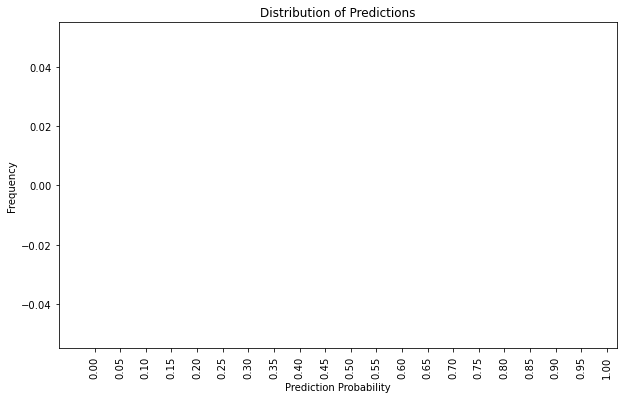

In [51]:
import numpy as np
from scipy.interpolate import interp1d

def histogram_equalization(predictions, n_bins=20):
    # Calculate the histogram and CDF
    hist, bin_edges = np.histogram(predictions, bins=n_bins)
    cdf = np.cumsum(hist)
    
    # Normalize the CDF
    cdf_min = np.min(cdf)
    cdf_max = np.max(cdf)
    cdf_normalized = (cdf - cdf_min) / (cdf_max - cdf_min)
    
    # Create a mapping function using the normalized CDF
    mapping_func = interp1d(bin_edges[:-1], cdf_normalized, kind='linear', fill_value="extrapolate")
    
    # Map the original predictions to equalized predictions
    equalized_predictions = mapping_func(predictions)
    
    return equalized_predictions
equalized_predictions = histogram_equalization(predictions, n_bins=20)
lambda_value = 4
transformed_predictions = (predictions**lambda_value - 1) / lambda_value

hist, _ = np.histogram(transformed_predictions, bins=bins)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=0.04)
plt.xticks(bins, rotation=90)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions")
plt.show()

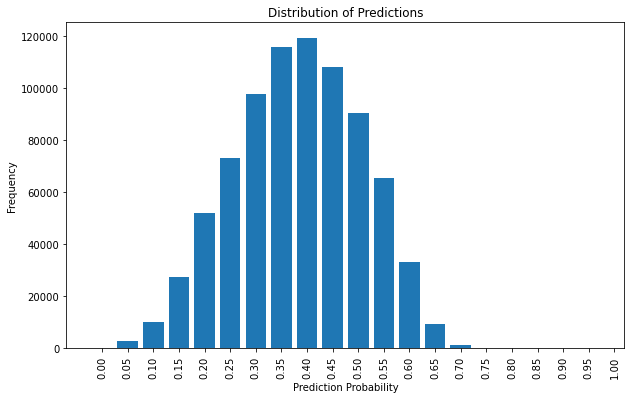

In [52]:
import matplotlib.pyplot as plt
import numpy as np
predictions = gbm_model.predict(dtest)
bins = np.arange(0, 1.05, 0.05)

# Count the number of predictions in each bin
hist, _ = np.histogram(predictions, bins=bins)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=0.04)
plt.xticks(bins, rotation=90)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions")
plt.show()

In [33]:
from sklearn.linear_model import LogisticRegression
predictions = gbm_model.predict(dtest)

predictions_val = predictions
y_val = y_test
# Reshape the predictions to be 2D as required by LogisticRegression
predictions_val_2d = predictions_val.reshape(-1, 1)

log_reg = LogisticRegression()
log_reg.fit(predictions_val_2d, y_val)

predictions_test = gbm_model.predict(xgb.DMatrix(X_test))
predictions_test_2d = predictions_test.reshape(-1, 1)

calibrated_predictions_test = log_reg.predict_proba(predictions_test_2d)[:, 1]


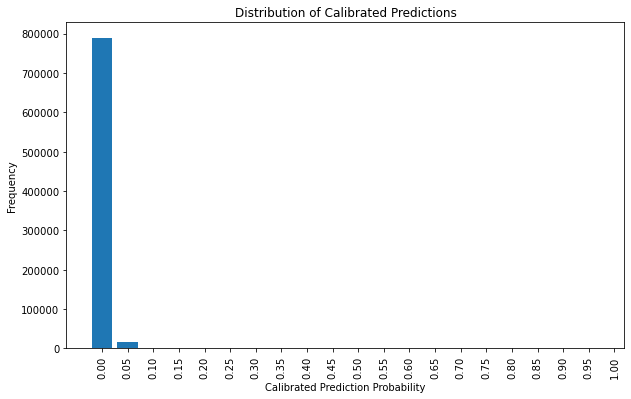

In [34]:
bins = np.arange(0, 1.05, 0.05)
hist, _ = np.histogram(calibrated_predictions_test, bins=bins)

plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=0.04)
plt.xticks(bins, rotation=90)
plt.xlabel("Calibrated Prediction Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Calibrated Predictions")
plt.show()

In [36]:
file = 'forex_ml_training_data_2016-01-01_2022-07-31_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
X = X[cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
print_results(gbm_model,dtest,y_test,label = 'TEST')


(849221, 76)
(679376, 53) (169845, 53)
RESULTS: TEST
AUC Score: 0.6755
Precision Score: 0.0476
Recall Score: 0.0368
Confusion Matrix:
[[164611   2220]
 [  2903    111]]
WINS: 111 TRADES: 2331


In [14]:
4244 / 6

707.3333333333334

In [18]:
win_rate = 0.07
loss_rate = 1 - win_rate

rr = 20
num_trades = int(1378 / 6)
ev = (win_rate * rr) - (loss_rate * 1) 
print('EV:',ev)
bal = 10000
for i in range(num_trades):
    bal += (bal * (ev/100))
bal



EV: 0.4700000000000002


29264.16369360669

In [26]:

win_rate = 0.0744
loss_rate = 1 - win_rate

rr = 20
num_trades = 4612
ev = (win_rate * rr) - (loss_rate * 1) 

bal = 10000
for i in range(num_trades):
    bal += (bal * (ev/100))
bal


1004535.6050534587

In [24]:
ev / 100

0.0056240000000000005

In [21]:
(loss_rate * 1)

0.9256

In [93]:
bal = 10000
for i in range(3841):
    bal += (bal * .011)
bal

1.7749602234448919e+22

In [23]:
#from sklearn.neighbors import DistanceMetric
import numpy as np
from sklearn.neighbors import NearestNeighbors

def generate_synthetic_samples(X, y, target_ratio=1.0, k_neighbors=5):
    # Get the minority and majority class indices
    minority_class_indices = np.where(y == 1)[0]
    majority_class_indices = np.where(y == 0)[0]
    
    # Calculate the number of synthetic samples needed
    n_minority = len(minority_class_indices)
    n_majority = len(majority_class_indices)
    n_synthetic_samples = int(target_ratio * n_majority) - n_minority
    
    # Initialize synthetic samples array
    synthetic_samples = np.zeros((n_synthetic_samples, X.shape[1]))
    
    # Train a k-nearest neighbors model on the minority class
    knn = NearestNeighbors(n_neighbors=k_neighbors).fit(X[minority_class_indices])
    #knn = NearestNeighbors(n_neighbors=k_neighbors).fit(X[X.index.isin(list(minority_class_indices))])
    
    
    for i in range(n_synthetic_samples):
        # Choose a random minority example
        chosen_index = np.random.choice(minority_class_indices)
        chosen_sample = X[chosen_index]
        
        # Find the k-nearest neighbors of the chosen example
        neighbors = knn.kneighbors(chosen_sample.reshape(1, -1), return_distance=False)
        
        # Choose a random neighbor
        neighbor_index = np.random.choice(neighbors[0])
        neighbor_sample = X[minority_class_indices][neighbor_index]
        
        # Generate a synthetic sample as a random point between the chosen example and its neighbor
        diff = neighbor_sample - chosen_sample
        gap = np.random.random()
        synthetic_sample = chosen_sample + gap * diff
        
        # Add the synthetic sample to the synthetic samples array
        synthetic_samples[i] = synthetic_sample
    
    # Combine the original dataset with the synthetic samples
    X_resampled = np.vstack((X, synthetic_samples))
    y_resampled = np.hstack((y, np.ones(n_synthetic_samples)))
    
    return X_resampled, y_resampled

X_train_,y_train_ = generate_synthetic_samples(X_train.values, y_train.values, target_ratio=1.0, k_neighbors=5)



KeyboardInterrupt: 

In [3]:
from annoy import AnnoyIndex
import numpy as np
def generate_synthetic_samples(X, y, target_ratio=1.0, k_neighbors=5):
    # Get the minority and majority class indices
    minority_class_indices = np.where(y == 1)[0]
    majority_class_indices = np.where(y == 0)[0]
    
    # Calculate the number of synthetic samples needed
    n_minority = len(minority_class_indices)
    n_majority = len(majority_class_indices)
    n_synthetic_samples = int(target_ratio * n_majority) - n_minority
    
    # Initialize synthetic samples array
    synthetic_samples = np.zeros((n_synthetic_samples, X.shape[1]))
    
    # Train an Annoy index on the minority class
    minority_X = X[minority_class_indices]
    n_features = minority_X.shape[1]
    annoy_index = AnnoyIndex(n_features, 'euclidean')
    for i, x in enumerate(minority_X):
        annoy_index.add_item(i, x)
    annoy_index.build(10)  # Number of trees in the index, higher is more accurate but slower
    
    for i in range(n_synthetic_samples):
        # Choose a random minority example
        chosen_index = np.random.choice(minority_class_indices)
        chosen_sample = X[chosen_index]
        
        # Find the k-nearest neighbors of the chosen example using Annoy
        neighbors = annoy_index.get_nns_by_vector(chosen_sample, k_neighbors, include_distances=False)
        
        # Choose a random neighbor
        neighbor_index = np.random.choice(neighbors)
        neighbor_sample = minority_X[neighbor_index]
        
        # Generate a synthetic sample as a random point between the chosen example and its neighbor
        diff = neighbor_sample - chosen_sample
        gap = np.random.random()
        synthetic_sample = chosen_sample + gap * diff
        
        # Add the synthetic sample to the synthetic samples array
        synthetic_samples[i] = synthetic_sample
    
    # Combine the original dataset with the synthetic samples
    X_resampled = np.vstack((X, synthetic_samples))
    y_resampled = np.hstack((y, np.ones(n_synthetic_samples)))
    
    return X_resampled, y_resampled

X_train_,y_train_ = generate_synthetic_samples(X_train.values, y_train.values, target_ratio=1.0, k_neighbors=5)

X_train = pd.DataFrame(X_train_,columns = X_train.columns)
y_train = pd.Series(y_train_)

In [4]:
y_train

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1221569    1.0
1221570    1.0
1221571    1.0
1221572    1.0
1221573    1.0
Length: 1221574, dtype: float64

In [24]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 kB 1.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-macosx_10_12_x86_64.whl size=77996 sha256=9aa88c09bd8e23430dcbf6cfe0ad2fb36175adacca08a2f7717e6817b5df54a8
  Stored in directory: /Users/aidanmcconnell/Library/Caches/pip/wheels/bf/c8/76/273824b7fbbe5c4927d5038898068eb1523155f327d57de3b6
Successfully built annoy

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
X.shape

(627450, 75)

In [21]:
X.values[237041].shape

(75,)

In [17]:
X.iloc[237041,:]

bearish_engulfing          0.0
bullish_engulfing          0.0
bearish_tls                0.0
bullish_tls                0.0
previous_hour_volume    4480.0
                         ...  
AUD_USD                    0.0
NZD_USD                    0.0
USD_CHF                    0.0
USD_CAD                    0.0
EUR_CHF                    0.0
Name: 734460, Length: 75, dtype: float64

In [7]:
y = y_train
target_ratio = 1.0
X = X_train
k_neighbors = 5
minority_class_indices = np.where(y == 1)[0]
majority_class_indices = np.where(y == 0)[0]

# Calculate the number of synthetic samples needed
n_minority = len(minority_class_indices)
n_majority = len(majority_class_indices)
n_synthetic_samples = int(target_ratio * n_majority) - n_minority

# Initialize synthetic samples array
synthetic_samples = np.zeros((n_synthetic_samples, X.shape[1]))

# Train a k-nearest neighbors model on the minority class
knn = NearestNeighbors(n_neighbors=k_neighbors).fit(X[minority_class_indices])



KeyError: "None of [Int64Index([    33,     54,    113,    174,    214,    228,    231,    246,\n               251,    334,\n            ...\n            627071, 627105, 627237, 627242, 627268, 627329, 627345, 627361,\n            627367, 627445],\n           dtype='int64', length=16663)] are in the [columns]"

In [14]:
X[X.index.isin(list(minority_class_indices))]

,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,previous_bullish_24hour,...,AUD_CAD,AUD_NZD,NZD_CAD,USD_JPY,GBP_USD,AUD_USD,NZD_USD,USD_CHF,USD_CAD,EUR_CHF
68358,0,0,0,0,906,8402,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
220349,0,0,0,0,2123,10332,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204797,0,0,0,0,310,1114,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
251043,0,0,0,0,5060,13751,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
516367,0,0,0,0,448,1982,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,0,0,0,0,459,2621,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
139182,0,1,0,0,1377,7162,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
432315,0,0,0,0,3093,26132,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
561353,0,0,0,0,2320,7264,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train.head()

,bearish_engulfing,bullish_engulfing,bearish_tls,bullish_tls,previous_hour_volume,previous_4_hour_volume,previous_bullish_hour,previous_bullish_4hour,previous_bullish_8hour,previous_bullish_24hour,...,AUD_CAD,AUD_NZD,NZD_CAD,USD_JPY,GBP_USD,AUD_USD,NZD_USD,USD_CHF,USD_CAD,EUR_CHF
682553,0,0,0,0,7843,22365,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
653973,0,0,0,0,2341,12377,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666427,0,0,0,0,2874,12240,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203527,0,0,0,0,725,1994,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
217523,0,0,0,0,1405,8684,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [104]:
!pip install --upgrade scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!conda update scikit-learn
!y

In [ ]:
!y

In [101]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



ImportError: cannot import name '_OneToOneFeatureMixin' from 'sklearn.base' (/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py)

In [84]:
66 / (66 + 309)

0.176

In [88]:
cm[1][1]

66

In [78]:
prop = (df[df['target'] == 1].shape[0]/df.shape[0])  * 100
scale_pos_weight = (100 - prop) / prop
scale_pos_weight

36.53771417631856

In [75]:
prop * 100

2.6639874641884043

In [76]:
(100 - 2.6) / 2.6

37.46153846153846

In [77]:
prop

0.026639874641884043

# Keras Model

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
cols = ['bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'previous_hour_volume', 'previous_4_hour_volume',
       'previous_bullish_hour', 'previous_bullish_4hour',
       'previous_bullish_8hour', 'previous_bullish_24hour',
       'previous_bullish_50hour', 'previous_bullish_120hour',
       'previous_bullish_250hour', 'previous_bullish_400hour',
       'previous_delta_hour', 'previous_delta_4hour', 'previous_delta_8hour',
       'previous_delta_24hour', 'previous_delta_50hour',
       'previous_delta_120hour', 'previous_delta_250hour',
       'previous_delta_400hour', 'previous_lower_wick_hour',
       'previous_upper_wick_hour', 'low_at_low_of_last_day',
       'low_at_low_of_last_5day', 'low_at_low_of_last_10day',
       'low_at_low_of_last_20day', 'high_at_high_of_last_day',
       'high_at_high_of_last_5day', 'high_at_high_of_last_10day',
       'high_at_high_of_last_20day',
       'close_difference_from_low_close_of_last_day',
       'close_difference_from_low_close_of_last_5day',
       'close_difference_from_low_close_of_last_10day',
       'close_difference_from_high_close_of_last_day',
       'close_difference_from_high_close_of_last_5day',
       'close_difference_from_high_close_of_last_10day', 'hour_0_3',
       'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
       'previous_5_min_volume', 'previous_15_min_volume', 'bullish_ema_5min',
       'bearish_ema_5min', 'previous_bullish_5min', 'previous_delta_5min',
       'bearish_engulfing5', 'bullish_engulfing5', 'bearish_tls5']
file = 'forex_ml_training_data_2010-01-01_2016-01-01_TP_100_SL_5_BULLISH_True.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()
X = df.drop(columns = ['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)


class_weight = {0: 1.0, 1: (len(y_train) - np.sum(y_train)) / np.sum(y_train)}
# Define the model architecture
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train[cols].shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# Train the model
history = model.fit(X_train[cols], y_train, epochs=10, batch_size=64, validation_split=0.2, 
                    class_weight=class_weight)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test[cols], y_test)

# Make predictions on the test set
y_pred = model.predict(X_test[cols])
y_pred_classes = (y_pred > 0.5).astype('int32')

# Print classification results
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_classes))


(784313, 76)
(627450, 75) (156863, 75)
Epoch 1/10
7844/7844 [==============================] - 13s 1ms/step - loss: 1.3279 - accuracy: 0.5462 - precision: 0.0345 - auc: 0.5956 - val_loss: 0.6446 - val_accuracy: 0.6290 - val_precision: 0.0374 - val_auc: 0.6163
Epoch 2/10
7844/7844 [==============================] - 12s 1ms/step - loss: 1.3060 - accuracy: 0.5179 - precision: 0.0351 - auc: 0.6143 - val_loss: 0.7371 - val_accuracy: 0.4922 - val_precision: 0.0342 - val_auc: 0.6124
Epoch 3/10
7844/7844 [==============================] - 13s 2ms/step - loss: 1.3032 - accuracy: 0.5209 - precision: 0.0357 - auc: 0.6180 - val_loss: 0.5518 - val_accuracy: 0.7261 - val_precision: 0.0381 - val_auc: 0.6056
Epoch 4/10
7844/7844 [==============================] - 12s 2ms/step - loss: 1.3001 - accuracy: 0.5151 - precision: 0.0359 - auc: 0.6227 - val_loss: 0.6497 - val_accuracy: 0.5541 - val_precision: 0.0370 - val_auc: 0.6281
Epoch 5/10
6100/7844 [======================>.......] - ETA: 2s - loss: 1.304

KeyboardInterrupt: 

In [7]:
model.evaluate(X_test[cols], y_test)

4902/4902 [==============================] - 4s 877us/step - loss: 0.7177 - accuracy: 0.5113 - precision: 0.0342 - auc: 0.5967


[0.7176565527915955,
 0.5112805366516113,
 0.034187816083431244,
 0.5966548919677734]

In [13]:
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 1.24.1


NameError: name 'tf' is not defined

In [14]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 20.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.1.73 requires requests>=2.26, but you have requests 2.24.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [19]:
!pip install --upgrade tensorflow

In [18]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 764.2 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


In [11]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.23.5-cp38-cp38-macosx_10_9_x86_64.whl (18.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 2.6 MB/s eta 0:00:

In [9]:
X_train.columns

Index(['bearish_engulfing', 'bullish_engulfing', 'bearish_tls', 'bullish_tls',
       'previous_hour_volume', 'previous_4_hour_volume',
       'previous_bullish_hour', 'previous_bullish_4hour',
       'previous_bullish_8hour', 'previous_bullish_24hour',
       'previous_bullish_50hour', 'previous_bullish_120hour',
       'previous_bullish_250hour', 'previous_bullish_400hour',
       'previous_delta_hour', 'previous_delta_4hour', 'previous_delta_8hour',
       'previous_delta_24hour', 'previous_delta_50hour',
       'previous_delta_120hour', 'previous_delta_250hour',
       'previous_delta_400hour', 'previous_lower_wick_hour',
       'previous_upper_wick_hour', 'low_at_low_of_last_day',
       'low_at_low_of_last_5day', 'low_at_low_of_last_10day',
       'low_at_low_of_last_20day', 'high_at_high_of_last_day',
       'high_at_high_of_last_5day', 'high_at_high_of_last_10day',
       'high_at_high_of_last_20day',
       'close_difference_from_low_close_of_last_day',
       'close_differenc